# Education Data Analysis - Gender in Month vs Grades

## 0. Importing, reading, cleaning

Execute this cells one by one or your kernell might die

In [1]:
import psutil
print(psutil.virtual_memory())

svmem(total=34359738368, available=21727526912, percent=36.8, used=11677085696, free=13193940992, active=7540441088, inactive=5948801024, wired=4136644608)


In [2]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress  # for linear regression


In [3]:
# Load secondary data (first file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()

df_S = pd.DataFrame(secondary_data)

# Load primary data (second file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])

primary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()

df_P = pd.DataFrame(primary_data)

In [4]:
# Set first row as header
df_P.columns = df_P.iloc[0]
df_P = df_P[1:]
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]
df_S = df_S[1:]
df_S.reset_index(drop=True, inplace=True)

In [5]:
# UPDATED SO THAT THE KERNEL DOES NOT CRASH
import gc

# Keep only students present in both datasets
students_P = set(df_P['CODI_ALUMNE'].unique())
students_S = set(df_S['CODI_ALUMNE'].unique())

# Find matching students
matching_students = students_P.intersection(students_S)

print(f"Students in Primary: {len(students_P)}")
print(f"Students in Secondary: {len(students_S)}")
print(f"Matching students: {len(matching_students)}")

# Filter both dataframes
df_P = df_P[df_P['CODI_ALUMNE'].isin(matching_students)].copy()
df_S = df_S[df_S['CODI_ALUMNE'].isin(matching_students)].copy()

df_P.reset_index(drop=True, inplace=True)
df_S.reset_index(drop=True, inplace=True)

# Clear memory
gc.collect()


Students in Primary: 513377
Students in Secondary: 532090
Matching students: 251748


0

In [6]:
# UPDATED SO THAT THE KERNEL DOES NOT CRASH
import gc

def convert_grades_to_numeric(df, prefix='P'):
    """
    Convert grade columns from comma-separated strings to numeric floats.
    Optimized for large datasets with memory management.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    prefix : str
        Column prefix to identify grade columns (default: 'P')
    
    Returns:
    --------
    list : Column names that were converted
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix) and df[c].dtype == 'object']
    
    print(f"Found {len(grade_cols)} columns to convert...")
    
    for i, col in enumerate(grade_cols):
        try:
            # Replace comma with dot for decimal conversion
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
            # Convert to numeric (invalid parsing becomes NaN)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            if (i + 1) % 5 == 0:  # Progress check every 5 columns
                print(f"  Converted {i + 1}/{len(grade_cols)} columns...")
                gc.collect()
        
        except Exception as e:
            print(f"  Warning: Could not convert column {col}: {e}")
            continue
    
    return grade_cols


# Apply conversion separately to Primary and Secondary
print("Converting Primary grades...")
converted_P = convert_grades_to_numeric(df_P, prefix='P')
gc.collect()

print("Converting Secondary grades...")
converted_S = convert_grades_to_numeric(df_S, prefix='P')
gc.collect()

print(f"\nConverted {len(converted_P)} columns in Primary")
print(f"Converted {len(converted_S)} columns in Secondary")


Converting Primary grades...
Found 24 columns to convert...
  Converted 5/24 columns...
  Converted 10/24 columns...
  Converted 15/24 columns...
  Converted 20/24 columns...
Converting Secondary grades...
Found 28 columns to convert...
  Converted 5/28 columns...
  Converted 10/28 columns...
  Converted 15/28 columns...
  Converted 20/28 columns...
  Converted 25/28 columns...

Converted 24 columns in Primary
Converted 28 columns in Secondary


### Secondary Education

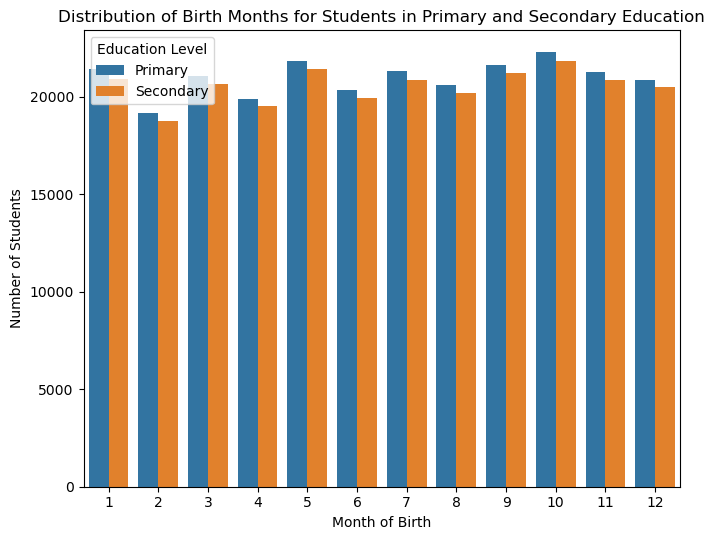

In [7]:
# ===============================
# Plot 1: Distribution of Birth Months
# ===============================
df_birth_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT']].drop_duplicates()
df_birth_P['snapshot'] = 'Primary'

df_birth_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT']].drop_duplicates()
df_birth_S['snapshot'] = 'Secondary'

# Combine for plotting only
df_birth_months = pd.concat([df_birth_P, df_birth_S], ignore_index=True)

# Order the months correctly, from 1 to 12
df_birth_months['MES_NAIXEMENT'] = pd.Categorical(df_birth_months['MES_NAIXEMENT'], 
                                                  categories=[str(i) for i in range(1, 13)], ordered=True)

plt.figure(figsize=(7, 5.5))
sns.countplot(data=df_birth_months, x='MES_NAIXEMENT', hue='snapshot')
plt.title('Distribution of Birth Months for Students in Primary and Secondary Education')
plt.xlabel('Month of Birth')
plt.ylabel('Number of Students')
plt.legend(title='Education Level', labels=['Primary', 'Secondary'])
plt.tight_layout()
plt.show()

PRIMARY EDUCATION - Mathematics (PMAT)
Total students: 251748
Mean grade: 79.37
Median grade: 82.33
Std Dev: 15.12
Min: 2.59
Max: 100.00
25th percentile: 70.53
75th percentile: 91.05

SECONDARY EDUCATION - Mathematics (PMAT)
Total students: 251748
Mean grade: 66.62
Median grade: 68.25
Std Dev: 20.11
Min: 0.00
Max: 100.00
25th percentile: 52.08
75th percentile: 83.08



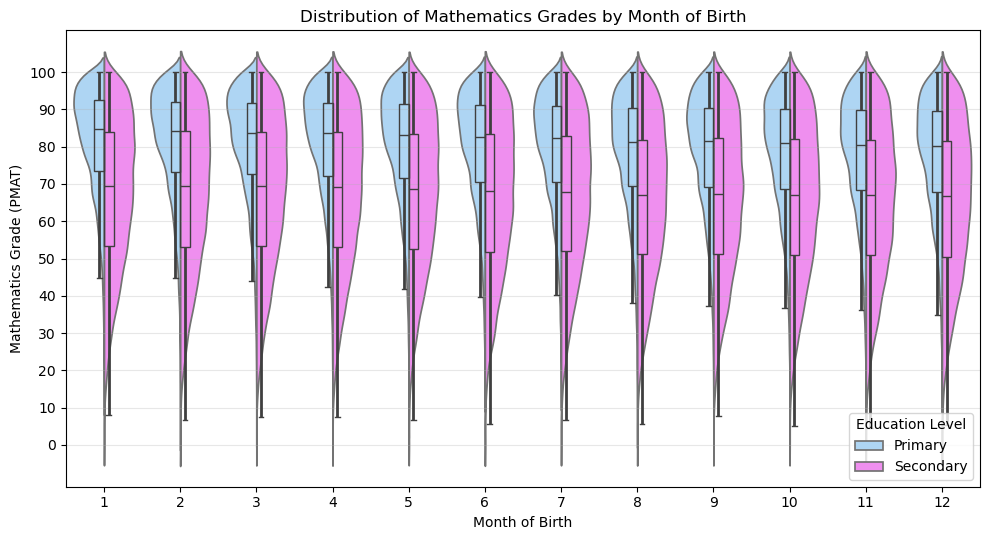

In [22]:
# ===============================
# Analysis: Primary Education
# ===============================
df_math_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PMAT']].drop_duplicates(subset='CODI_ALUMNE')
df_math_P['MES_NAIXEMENT'] = pd.Categorical(df_math_P['MES_NAIXEMENT'], 
                                            categories=[str(i) for i in range(1, 13)], ordered=True)
df_math_P['snapshot'] = 'Primary'

# Summary statistics for Primary
print("=" * 50)
print("PRIMARY EDUCATION - Mathematics (PMAT)")
print("=" * 50)
print(f"Total students: {len(df_math_P)}")
print(f"Mean grade: {df_math_P['PMAT'].mean():.2f}")
print(f"Median grade: {df_math_P['PMAT'].median():.2f}")
print(f"Std Dev: {df_math_P['PMAT'].std():.2f}")
print(f"Min: {df_math_P['PMAT'].min():.2f}")
print(f"Max: {df_math_P['PMAT'].max():.2f}")
print(f"25th percentile: {df_math_P['PMAT'].quantile(0.25):.2f}")
print(f"75th percentile: {df_math_P['PMAT'].quantile(0.75):.2f}")
print()


# ===============================
# Analysis: Secondary Education
# ===============================
df_math_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PMAT']].drop_duplicates(subset='CODI_ALUMNE')
df_math_S['MES_NAIXEMENT'] = pd.Categorical(df_math_S['MES_NAIXEMENT'], 
                                            categories=[str(i) for i in range(1, 13)], ordered=True)
df_math_S['snapshot'] = 'Secondary'

# Summary statistics for Secondary
print("=" * 50)
print("SECONDARY EDUCATION - Mathematics (PMAT)")
print("=" * 50)
print(f"Total students: {len(df_math_S)}")
print(f"Mean grade: {df_math_S['PMAT'].mean():.2f}")
print(f"Median grade: {df_math_S['PMAT'].median():.2f}")
print(f"Std Dev: {df_math_S['PMAT'].std():.2f}")
print(f"Min: {df_math_S['PMAT'].min():.2f}")
print(f"Max: {df_math_S['PMAT'].max():.2f}")
print(f"25th percentile: {df_math_S['PMAT'].quantile(0.25):.2f}")
print(f"75th percentile: {df_math_S['PMAT'].quantile(0.75):.2f}")
print()


# ===============================
# Plot 2: Mathematics Grades by Birth Month (Violin Distribution)
# ===============================
# Combine dataframes for plotting only
df_math_grades = pd.concat([df_math_P, df_math_S], ignore_index=True)

# Order the months correctly, from 1 to 12
df_math_grades['MES_NAIXEMENT'] = pd.Categorical(df_math_grades['MES_NAIXEMENT'], 
                                                 categories=[str(i) for i in range(1, 13)], ordered=True)


plt.figure(figsize=(10, 5.5))

# use the defined colors in the plot
sns.violinplot(data=df_math_grades, x='MES_NAIXEMENT', y='PMAT', hue='snapshot', 
               palette=[primary_color, secondary_color], split=True, inner=None)
sns.boxplot(data=df_math_grades, x='MES_NAIXEMENT', y='PMAT', hue='snapshot', showcaps=True,
    boxprops={'facecolor':'none', 'zorder':3}, showfliers=False, whiskerprops={'linewidth':2},width=0.25)

# Set y-axis ticks every 10 points
plt.yticks(range(0, 101, 10))


plt.title('Distribution of Mathematics Grades by Month of Birth')
plt.xlabel('Month of Birth')
plt.ylabel('Mathematics Grade (PMAT)')
plt.legend(title='Education Level', labels=['Primary', 'Secondary'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Plots

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_5380/2031061982.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stats_P = df_math_P.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).reset_index()
/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_5380/2031061982.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stats_S = df_math_S.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).reset_index()


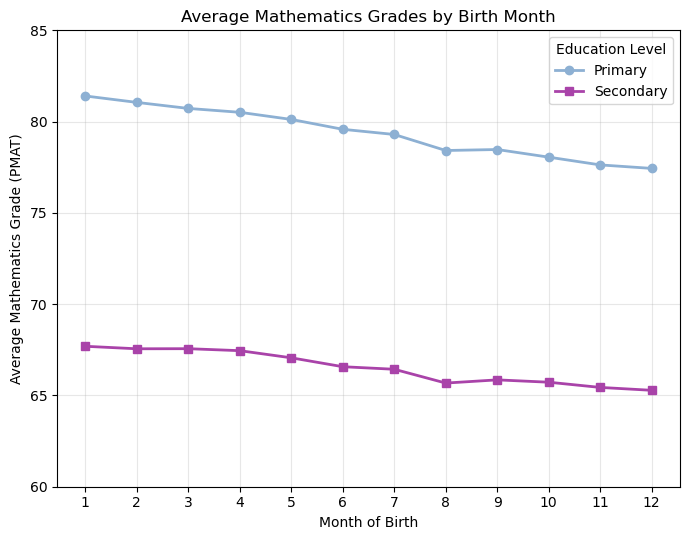

In [18]:
# ===============================
# Plot 3: Average Mathematics Grades by Birth Month with Error Bars
# ===============================
# Calculate mean and standard error for each birth month and education level
df_stats_P = df_math_P.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).reset_index()
df_stats_P['se'] = df_stats_P['std'] / np.sqrt(df_stats_P['count'])
df_stats_P['snapshot'] = 'Primary'


df_stats_S = df_math_S.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).reset_index()
df_stats_S['se'] = df_stats_S['std'] / np.sqrt(df_stats_S['count'])
df_stats_S['snapshot'] = 'Secondary'



# Convert month to numeric for plotting
df_stats_P['month_num'] = df_stats_P['MES_NAIXEMENT'].astype(str).astype(int)
df_stats_S['month_num'] = df_stats_S['MES_NAIXEMENT'].astype(str).astype(int)


plt.figure(figsize=(7, 5.5))


# Plot Primary data
plt.plot(df_stats_P['month_num'], df_stats_P['mean'], 
         marker='o', linewidth=2, label='Primary', color="#8DB0D3")


# Plot Secondary data
plt.plot(df_stats_S['month_num'], df_stats_S['mean'], 
         marker='s', linewidth=2, label='Secondary', color="#A943A9")



plt.xlabel('Month of Birth')
plt.ylabel('Average Mathematics Grade (PMAT)')
plt.title('Average Mathematics Grades by Birth Month')
plt.xticks(range(1, 13))
plt.yticks(range(60, 86, 5))
# Set yrange between 60 and 85
plt.ylim(60, 85)
plt.legend(title='Education Level')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


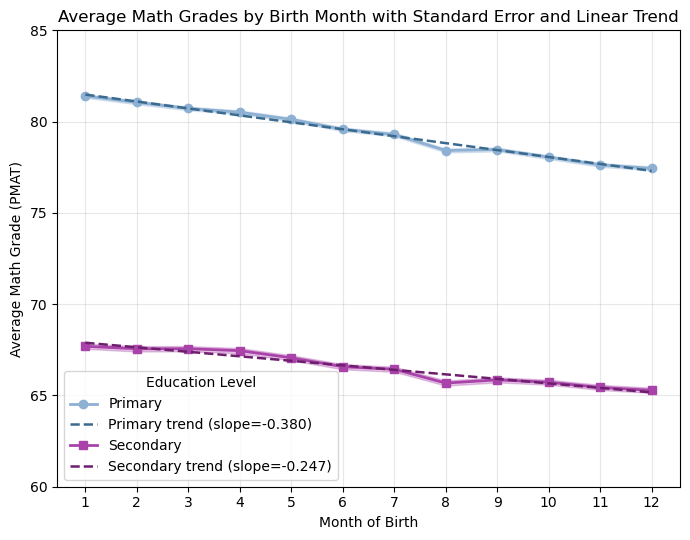

    snapshot     slope  intercept   r_value       p_value    stderr
0    Primary -0.380133  81.861592 -0.993868  6.756924e-11  0.013374
1  Secondary -0.247240  68.132875 -0.975187  7.105934e-08  0.017749


In [21]:
# ===============================
# Plot 3: Average Mathematics Grades by Birth Month with Error Bands
# + Linear Regression Slopes
# ===============================
import matplotlib.pyplot as plt
from scipy import stats as sci_stats  # for linear regression

# Ensure MES_NAIXEMENT is numeric for sorting/axis
df_math_P_local = df_math_P.copy()
df_math_S_local = df_math_S.copy()
df_math_P_local['MES_NAIXEMENT'] = pd.to_numeric(df_math_P_local['MES_NAIXEMENT'], errors='coerce')
df_math_S_local['MES_NAIXEMENT'] = pd.to_numeric(df_math_S_local['MES_NAIXEMENT'], errors='coerce')

# Drop rows with missing month or grade to avoid fill_between issues
df_math_P_local = df_math_P_local.dropna(subset=['MES_NAIXEMENT', 'PMAT'])
df_math_S_local = df_math_S_local.dropna(subset=['MES_NAIXEMENT', 'PMAT'])

plt.figure(figsize=(7, 5.5))

# -----------------------------------
# Primary: compute mean, SE and fit regression
# -----------------------------------
stats_P = df_math_P_local.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).sort_index()
x_P = stats_P.index.values.astype(int)
y_P = stats_P['mean'].values
se_P = (stats_P['std'] / np.sqrt(stats_P['count'])).fillna(0).values

# Plot mean with error band
plt.plot(x_P, y_P, marker='o', linewidth=2, label='Primary', color="#8DB0D3")
plt.fill_between(x_P, y_P - se_P, y_P + se_P, alpha=0.3, color="#8DB0D3")

# Linear regression for Primary
slope_P, intercept_P, r_P, p_P, stderr_P = sci_stats.linregress(x_P, y_P)
y_P_fit = intercept_P + slope_P * x_P
plt.plot(x_P, y_P_fit, color="#3B6A8F", linestyle='--', linewidth=1.8,
         label=f'Primary trend (slope={slope_P:.3f})')

# -----------------------------------
# Secondary: compute mean, SE and fit regression
# -----------------------------------
stats_S = df_math_S_local.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).sort_index()
x_S = stats_S.index.values.astype(int)
y_S = stats_S['mean'].values
se_S = (stats_S['std'] / np.sqrt(stats_S['count'])).fillna(0).values

# Plot mean with error band
plt.plot(x_S, y_S, marker='s', linewidth=2, label='Secondary', color="#A943A9")
plt.fill_between(x_S, y_S - se_S, y_S + se_S, alpha=0.3, color="#A943A9")

# Linear regression for Secondary
slope_S, intercept_S, r_S, p_S, stderr_S = sci_stats.linregress(x_S, y_S)
y_S_fit = intercept_S + slope_S * x_S
plt.plot(x_S, y_S_fit, color="#6D1F6D", linestyle='--', linewidth=1.8,
         label=f'Secondary trend (slope={slope_S:.3f})')

# -----------------------------------
# Store slopes in a dataframe
# -----------------------------------
df_slopes = pd.DataFrame({
    'snapshot': ['Primary', 'Secondary'],
    'slope': [slope_P, slope_S],
    'intercept': [intercept_P, intercept_S],
    'r_value': [r_P, r_S],
    'p_value': [p_P, p_S],
    'stderr': [stderr_P, stderr_S]
})

# If you want to keep accumulating across runs, you could append:
# df_all_slopes = pd.concat([df_all_slopes, df_slopes], ignore_index=True)

# Axes and formatting
plt.xlabel('Month of Birth')
plt.ylabel('Average Math Grade (PMAT)')
plt.title('Average Math Grades by Birth Month with Standard Error and Linear Trend')
plt.xticks(range(1, 13))
plt.yticks(range(60, 86, 5))
plt.ylim(60, 85)
plt.legend(title='Education Level')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: inspect slopes
print(df_slopes)


### Thermalization

In [33]:
# ===============================
# Thermalization: randomize months
# ===============================
import numpy as np

# Copy and ensure numeric months
df_math_P_therm = df_math_P.copy()
df_math_S_therm = df_math_S.copy()

df_math_P_therm['MES_NAIXEMENT'] = pd.to_numeric(df_math_P_therm['MES_NAIXEMENT'],
                                                 errors='coerce')
df_math_S_therm['MES_NAIXEMENT'] = pd.to_numeric(df_math_S_therm['MES_NAIXEMENT'],
                                                 errors='coerce')

# Drop rows with missing month or grade
df_math_P_therm = df_math_P_therm.dropna(subset=['MES_NAIXEMENT', 'PMAT'])
df_math_S_therm = df_math_S_therm.dropna(subset=['MES_NAIXEMENT', 'PMAT'])

# Fix seed for reproducibility if you want
rng = np.random.default_rng(seed=42)

# --- Randomly assign each student to a month 1..12 (thermalized months) ---
df_math_P_therm['MES_NAIXEMENT_TH'] = rng.integers(1, 13, size=len(df_math_P_therm))
df_math_S_therm['MES_NAIXEMENT_TH'] = rng.integers(1, 13, size=len(df_math_S_therm))

# --- Original stats (for reference) ---
stats_P = df_math_P_therm.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).sort_index()
x_P = stats_P.index.values.astype(int)
y_P = stats_P['mean'].values
se_P = (stats_P['std'] / np.sqrt(stats_P['count'])).fillna(0).values

stats_S = df_math_S_therm.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).sort_index()
x_S = stats_S.index.values.astype(int)
y_S = stats_S['mean'].values
se_S = (stats_S['std'] / np.sqrt(stats_S['count'])).fillna(0).values

# --- Thermalized stats (random months) ---
stats_P_th = df_math_P_therm.groupby('MES_NAIXEMENT_TH')['PMAT'].agg(['mean', 'std', 'count']).sort_index()
x_P_th = stats_P_th.index.values.astype(int)
y_P_th = stats_P_th['mean'].values

stats_S_th = df_math_S_therm.groupby('MES_NAIXEMENT_TH')['PMAT'].agg(['mean', 'std', 'count']).sort_index()
x_S_th = stats_S_th.index.values.astype(int)
y_S_th = stats_S_th['mean'].values


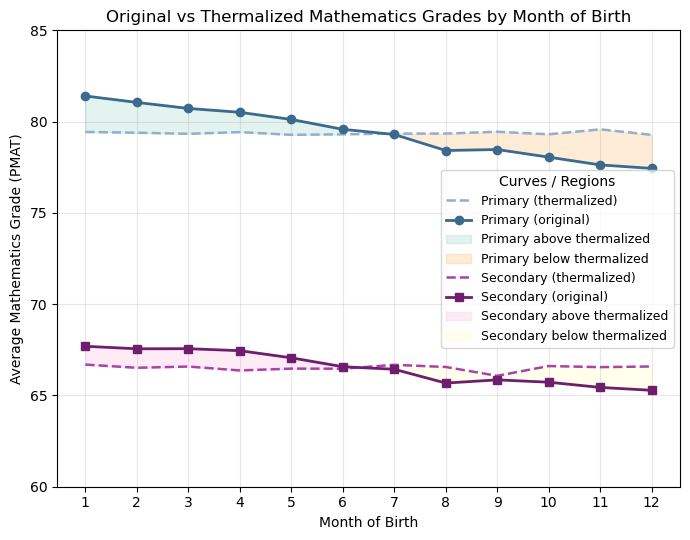

In [29]:
# ===============================
# Plot: original vs thermalized means
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5.5))

# ---- Primary: original + thermalized ----
# Plot thermalized means as reference (almost flat)
plt.plot(x_P_th, y_P_th, linestyle='--', linewidth=1.8,
         color="#8DB0D3", label='Primary (thermalized)')

# Plot original means
plt.plot(x_P, y_P, marker='o', linewidth=2, color="#3B6A8F",
         label='Primary (original)')

# Fill where original is above thermalized
plt.fill_between(
    x_P, y_P, np.interp(x_P, x_P_th, y_P_th),
    where=(y_P >= np.interp(x_P, x_P_th, y_P_th)),
    alpha=0.25, color='#8DD3C7', label='Primary above thermalized'
)

# Fill where original is below thermalized
plt.fill_between(
    x_P, y_P, np.interp(x_P, x_P_th, y_P_th),
    where=(y_P < np.interp(x_P, x_P_th, y_P_th)),
    alpha=0.25, color='#FDB462', label='Primary below thermalized'
)

# ---- Secondary: original + thermalized ----


# Plot thermalized means
plt.plot(x_S_th, y_S_th, linestyle='--', linewidth=1.8,
         color="#A943A9", label='Secondary (thermalized)')
# Plot original means
plt.plot(x_S, y_S, marker='s', linewidth=2, color="#6D1F6D",
         label='Secondary (original)')


# Fill where original is above thermalized
plt.fill_between(
    x_S, y_S, np.interp(x_S, x_S_th, y_S_th),
    where=(y_S >= np.interp(x_S, x_S_th, y_S_th)),
    alpha=0.25, color='#FFB3DE', label='Secondary above thermalized'
)

# Fill where original is below thermalized
plt.fill_between(
    x_S, y_S, np.interp(x_S, x_S_th, y_S_th),
    where=(y_S < np.interp(x_S, x_S_th, y_S_th)),
    alpha=0.25, color='#FFFFB3', label='Secondary below thermalized'
)

# Axes and formatting
plt.xlabel('Month of Birth')
plt.ylabel('Average Mathematics Grade (PMAT)')
plt.title('Original vs Thermalized Mathematics Grades by Month of Birth')
plt.xticks(range(1, 13))
plt.yticks(range(60, 86, 5))
plt.ylim(60, 85)
plt.legend(title='Curves / Regions', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:
# ===============================
# Thermalization múltiple (Matemàtiques, PMAT)
# ===============================
import numpy as np

# Local copies and numeric months
df_math_P_therm = df_math_P.copy()
df_math_S_therm = df_math_S.copy()

df_math_P_therm['MES_NAIXEMENT'] = pd.to_numeric(
    df_math_P_therm['MES_NAIXEMENT'], errors='coerce'
)
df_math_S_therm['MES_NAIXEMENT'] = pd.to_numeric(
    df_math_S_therm['MES_NAIXEMENT'], errors='coerce'
)

# Erases rows with mont/grade empty
df_math_P_therm = df_math_P_therm.dropna(subset=['MES_NAIXEMENT', 'PMAT'])
df_math_S_therm = df_math_S_therm.dropna(subset=['MES_NAIXEMENT', 'PMAT'])

# Months 1..12
months = np.arange(1, 13)

# --- Original statistics (for reference) ---
stats_P = df_math_P_therm.groupby('MES_NAIXEMENT')['PMAT'].agg(
    ['mean', 'std', 'count']
).sort_index()
x_P = stats_P.index.values.astype(int)
y_P = stats_P['mean'].values

stats_S = df_math_S_therm.groupby('MES_NAIXEMENT')['PMAT'].agg(
    ['mean', 'std', 'count']
).sort_index()
x_S = stats_S.index.values.astype(int)
y_S = stats_S['mean'].values

# --- Thermalitzacions múltiples ---
n_iter = 200  # pots pujar-ho si vols més suavitat
rng = np.random.default_rng(seed=42)

# Matrices [n_iter, 12] with the simulated mean per month
sim_P = np.full((n_iter, 12), np.nan)
sim_S = np.full((n_iter, 12), np.nan)

for i in range(n_iter):
    # Primary
    months_rand_P = rng.integers(1, 13, size=len(df_math_P_therm))
    tmp_P = df_math_P_therm.copy()
    tmp_P['MES_NAIXEMENT_TH'] = months_rand_P
    m_P = tmp_P.groupby('MES_NAIXEMENT_TH')['PMAT'].mean()

    # Omple vector de 12 mesos (1..12)
    arr_P = np.full(12, np.nan)
    for m, val in m_P.items():
        if 1 <= m <= 12:
            arr_P[m-1] = val
    sim_P[i, :] = arr_P

    # Secondary
    months_rand_S = rng.integers(1, 13, size=len(df_math_S_therm))
    tmp_S = df_math_S_therm.copy()
    tmp_S['MES_NAIXEMENT_TH'] = months_rand_S
    m_S = tmp_S.groupby('MES_NAIXEMENT_TH')['PMAT'].mean()

    arr_S = np.full(12, np.nan)
    for m, val in m_S.items():
        if 1 <= m <= 12:
            arr_S[m-1] = val
    sim_S[i, :] = arr_S

# --- Computes min-max and mean of the thermalizations ---
P_band_min = np.nanmin(sim_P, axis=0)
P_band_max = np.nanmax(sim_P, axis=0)
P_band_mean = np.nanmean(sim_P, axis=0)

S_band_min = np.nanmin(sim_S, axis=0)
S_band_max = np.nanmax(sim_S, axis=0)
S_band_mean = np.nanmean(sim_S, axis=0)


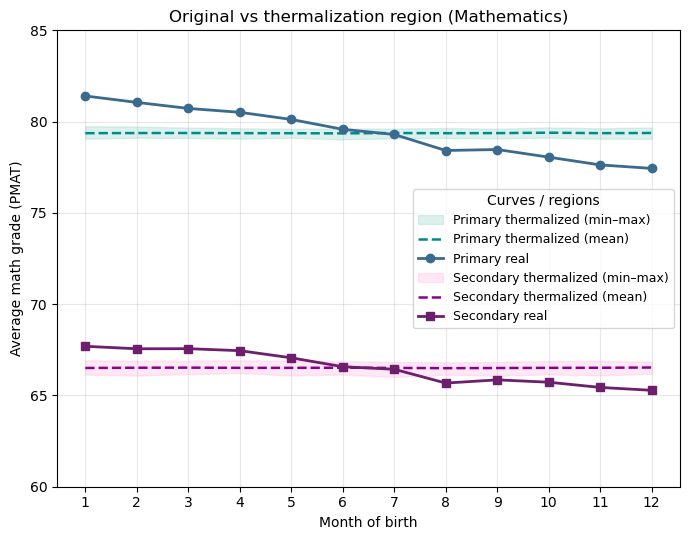

In [14]:
# ===============================
# Plot: Original vs thermalization region (Mathematics)
# ===============================
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 5.5))

# Ensure original means are on the full 1..12 grid
months = np.arange(1, 13)
y_P_on_grid = np.interp(months, x_P, y_P)
y_S_on_grid = np.interp(months, x_S, y_S)

# ---- Primary: noise band + simulated line + real points ----
plt.fill_between(
    months, P_band_min, P_band_max,
    color='#8DD3C7', alpha=0.3,
    label='Primary thermalized (min–max)'
)

plt.plot(
    months, P_band_mean,
    linestyle='--', linewidth=1.8, color='#008B8B',
    label='Primary thermalized (mean)'
)

plt.plot(
    months, y_P_on_grid,
    marker='o', linewidth=2, color='#3B6A8F',
    label='Primary real'
)

# ---- Secondary: noise band + simulated line + real points ----
plt.fill_between(
    months, S_band_min, S_band_max,
    color='#FFB3DE', alpha=0.3,
    label='Secondary thermalized (min–max)'
)

plt.plot(
    months, S_band_mean,
    linestyle='--', linewidth=1.8, color='#8B008B',
    label='Secondary thermalized (mean)'
)

plt.plot(
    months, y_S_on_grid,
    marker='s', linewidth=2, color='#6D1F6D',
    label='Secondary real'
)

# Axes and formatting in English
plt.xlabel('Month of birth')
plt.ylabel('Average math grade (PMAT)')
plt.title('Original vs thermalization region (Mathematics)')
plt.xticks(range(1, 13))
plt.yticks(range(60, 86, 5))
plt.ylim(60, 85)
plt.legend(title='Curves / regions', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



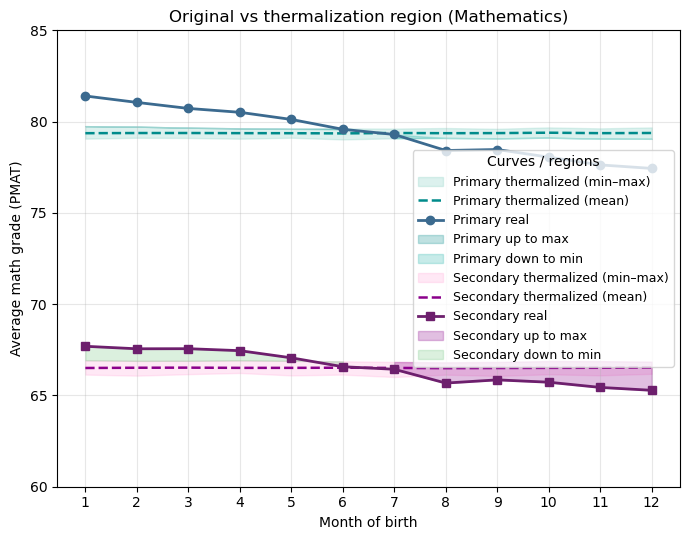

In [42]:
# ===============================
# Plot: Original vs thermalization region (Mathematics)
# with fills from real means to min–max band
# ===============================
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 5.5))

# Ensure original means are on the full 1..12 grid
months = np.arange(1, 13)
y_P_on_grid = np.interp(months, x_P, y_P)
y_S_on_grid = np.interp(months, x_S, y_S)

# ------------------------------------------------------------------
# PRIMARY
# ------------------------------------------------------------------

# 1) Base min–max thermalized band
plt.fill_between(
    months, P_band_min, P_band_max,
    color='#8DD3C7', alpha=0.3,
    label='Primary thermalized (min–max)'
)

# 2) Thermalized mean line
plt.plot(
    months, P_band_mean,
    linestyle='--', linewidth=1.8, color='#008B8B',
    label='Primary thermalized (mean)'
)

# 3) Real mean points
plt.plot(
    months, y_P_on_grid,
    marker='o', linewidth=2, color='#3B6A8F',
    label='Primary real'
)

# 4) Fill from real mean to min–max edges (no overlap outside band)
#    - if real >= band mean -> fill up to upper edge (P_band_max)
#    - if real <  band mean -> fill down to lower edge (P_band_min)

# Clip real values to band so fills stay inside min–max region
y_P_top_clipped = np.minimum(y_P_on_grid, P_band_max)
y_P_bottom_clipped = np.maximum(y_P_on_grid, P_band_min)

# Above band mean: fill from (clipped) real up to upper edge
plt.fill_between(
    months,
    y_P_top_clipped, P_band_max,
    where=(y_P_on_grid >= P_band_mean),
    alpha=0.25, color='#008B8B',
    label='Primary up to max'
)

# Below band mean: fill from (clipped) real down to lower edge
plt.fill_between(
    months,
    y_P_bottom_clipped, P_band_min,
    where=(y_P_on_grid < P_band_mean),
    alpha=0.25, color='#20B2AA',
    label='Primary down to min'
)

# ------------------------------------------------------------------
# SECONDARY
# ------------------------------------------------------------------

# 1) Base min–max band
plt.fill_between(
    months, S_band_min, S_band_max,
    color='#FFB3DE', alpha=0.3,
    label='Secondary thermalized (min–max)'
)

# 2) Thermalized mean line
plt.plot(
    months, S_band_mean,
    linestyle='--', linewidth=1.8, color='#8B008B',
    label='Secondary thermalized (mean)'
)

# 3) Real mean points
plt.plot(
    months, y_S_on_grid,
    marker='s', linewidth=2, color='#6D1F6D',
    label='Secondary real'
)

# 4) Fill from real mean to min–max edges

y_S_top_clipped = np.minimum(y_S_on_grid, S_band_max)
y_S_bottom_clipped = np.maximum(y_S_on_grid, S_band_min)

# Above band mean: fill to upper edge
plt.fill_between(
    months,
    y_S_top_clipped, S_band_max,
    where=(y_S_on_grid <= S_band_mean),
    alpha=0.25, color='#8B008B',
    label='Secondary up to max'
)

# Below band mean: fill to lower edge
plt.fill_between(
    months,
    y_S_bottom_clipped, S_band_max,
    where=(y_S_on_grid > S_band_mean),
    alpha=0.25, color="#71C57F",
    label='Secondary down to min'
)

# Axes and formatting in English
plt.xlabel('Month of birth')
plt.ylabel('Average math grade (PMAT)')
plt.title('Original vs thermalization region (Mathematics)')
plt.xticks(range(1, 13))
plt.yticks(range(60, 86, 5))
plt.ylim(60, 85)
plt.legend(title='Curves / regions', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Thermalization

In [23]:
# MAIN SUBJECTS:
subjects = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN', 'PMED']

subjects_P = [s for s in subjects if s in df_P.columns]
subjects_S = [s for s in subjects if s in df_S.columns]

print("Primary subjects:", subjects_P)
print("Secondary subjects:", subjects_S)


Primary subjects: ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
Secondary subjects: ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']


In [24]:
# --------------------------------------------------------
# 1. Thermalize one subject at one level
# --------------------------------------------------------
def thermalize_subject_by_month(df_level, grade_col, n_iter=200, seed=42):
    """
    df_level: dataframe with at least ['MES_NAIXEMENT', grade_col]
    grade_col: name of the grade column (string)
    Returns:
        summary: DataFrame with month-level stats (real mean, null mean, z, IQR, band, ...)
        sim:     array of shape (n_iter, 12) with simulated null means per month
    """
    df = df_level[['MES_NAIXEMENT', grade_col]].copy()
    df['MES_NAIXEMENT'] = pd.to_numeric(df['MES_NAIXEMENT'], errors='coerce')
    df = df.dropna(subset=['MES_NAIXEMENT', grade_col])

    months = np.arange(1, 13)

    # Real mean per month, aligned on full 1..12 grid
    real_means = (
        df.groupby('MES_NAIXEMENT')[grade_col]
          .mean()
          .reindex(months, fill_value=np.nan)
    )
    real_mean = real_means.values

    # Simulations: null distribution by randomizing months
    rng = np.random.default_rng(seed)
    sim = np.full((n_iter, len(months)), np.nan)

    for i in range(n_iter):
        months_rand = rng.integers(1, 13, size=len(df))
        tmp = df.copy()
        tmp['MES_NAIXEMENT_TH'] = months_rand
        m = tmp.groupby('MES_NAIXEMENT_TH')[grade_col].mean()

        arr = np.full(len(months), np.nan)
        for m_idx, val in m.items():
            if 1 <= m_idx <= 12:
                arr[m_idx - 1] = val
        sim[i, :] = arr

    # Null distribution summaries
    null_mean = np.nanmean(sim, axis=0)
    null_std  = np.nanstd(sim,  axis=0, ddof=1)
    null_med  = np.nanmedian(sim, axis=0)
    q1, q3    = np.nanpercentile(sim, [25, 75], axis=0)
    iqr       = q3 - q1

    # Z-score and robust z (IQR-based)
    z = (real_mean - null_mean) / null_std
    z_iqr = (real_mean - null_med) / iqr

    # Min–max band for visualization
    band_min = np.nanmin(sim, axis=0)
    band_max = np.nanmax(sim, axis=0)

    summary = pd.DataFrame({
        'month': months,
        'real_mean': real_mean,
        'null_mean': null_mean,
        'null_std': null_std,
        'null_median': null_med,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'z_score': z,
        'z_iqr': z_iqr,
        'band_min': band_min,
        'band_max': band_max
    })

    return summary, sim


In [25]:
# --------------------------------------------------------
# 1. Thermalize one subject, and interquartile range and zscore
# --------------------------------------------------------

def thermalize_subject_by_month(df_level, grade_col, n_iter=2000, seed=42):
    """
    df_level: dataframe with at least ['MES_NAIXEMENT', grade_col]
    grade_col: name of the grade column (string)

    Returns
    -------
    summary : DataFrame with month-level stats:
        month, real_mean, null_mean, null_std, null_median,
        q1, q3, iqr, z_score, z_iqr, band_min, band_max
    sim : np.ndarray of shape (n_iter, 12)
        simulated null means per month (months 1..12)
    """
    df = df_level[['MES_NAIXEMENT', grade_col]].copy()
    df['MES_NAIXEMENT'] = pd.to_numeric(df['MES_NAIXEMENT'], errors='coerce')
    df = df.dropna(subset=['MES_NAIXEMENT', grade_col])

    months = np.arange(1, 13)

    # Real mean per month on full grid 1..12
    real_means = (
        df.groupby('MES_NAIXEMENT')[grade_col]
          .mean()
          .reindex(months, fill_value=np.nan)
    )
    real_mean = real_means.values

    # Simulations: null distribution via month randomization
    rng = np.random.default_rng(seed)
    sim = np.full((n_iter, len(months)), np.nan)

    for i in range(n_iter):
        months_rand = rng.integers(1, 13, size=len(df))
        tmp = df.copy()
        tmp['MES_NAIXEMENT_TH'] = months_rand
        m = tmp.groupby('MES_NAIXEMENT_TH')[grade_col].mean()

        arr = np.full(len(months), np.nan)
        for m_idx, val in m.items():
            if 1 <= m_idx <= 12:
                arr[m_idx - 1] = val
        sim[i, :] = arr

    # Null distribution summaries
    null_mean = np.nanmean(sim, axis=0)
    null_std  = np.nanstd(sim,  axis=0, ddof=1)
    null_med  = np.nanmedian(sim, axis=0)
    q1, q3    = np.nanpercentile(sim, [25, 75], axis=0)
    iqr       = q3 - q1

    # Z-score and robust z (IQR-based)
    z = (real_mean - null_mean) / null_std
    z_iqr = (real_mean - null_med) / iqr

    # Min–max band for visualization
    band_min = np.nanmin(sim, axis=0)
    band_max = np.nanmax(sim, axis=0)

    summary = pd.DataFrame({
        'month': months,
        'real_mean': real_mean,
        'null_mean': null_mean,
        'null_std': null_std,
        'null_median': null_med,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'z_score': z,
        'z_iqr': z_iqr,
        'band_min': band_min,
        'band_max': band_max
    })

    return summary, sim


In [26]:
# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS
# --------------------------------------------------------
subjects_P = ['PCAT','PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# --------------------------------------------------------
# 2. Run analysis for all subjects
# --------------------------------------------------------
primary_summaries = {}   # dict: subj -> summary DataFrame
primary_sims = {}        # dict: subj -> sim array

for subj in subjects_P:
    df_subj_P = (
        df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    summary_P, sim_P = thermalize_subject_by_month(
        df_level=df_subj_P,
        grade_col='GRADE',
        n_iter=n_iter,
        seed=42  # can vary by subject if desired
    )

    summary_P['subject'] = subj
    summary_P['snapshot'] = 'Primary'

    primary_summaries[subj] = summary_P
    primary_sims[subj] = sim_P

# Long-format dataset with all Primary stats (includes z_score and z_iqr)
df_stats_primary_all = pd.concat(primary_summaries.values(), ignore_index=True)



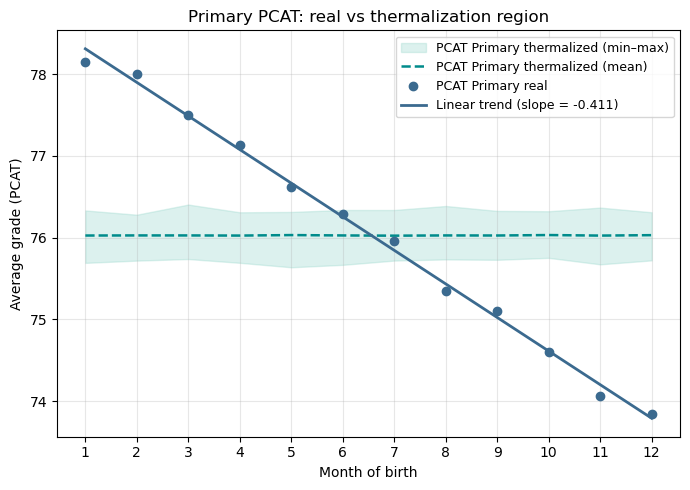

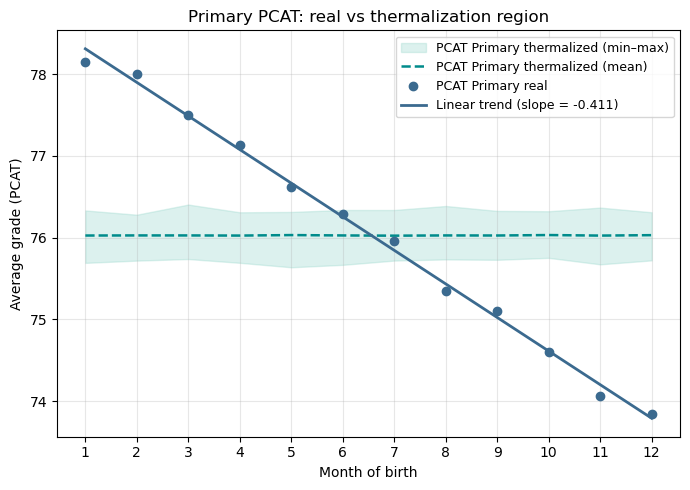

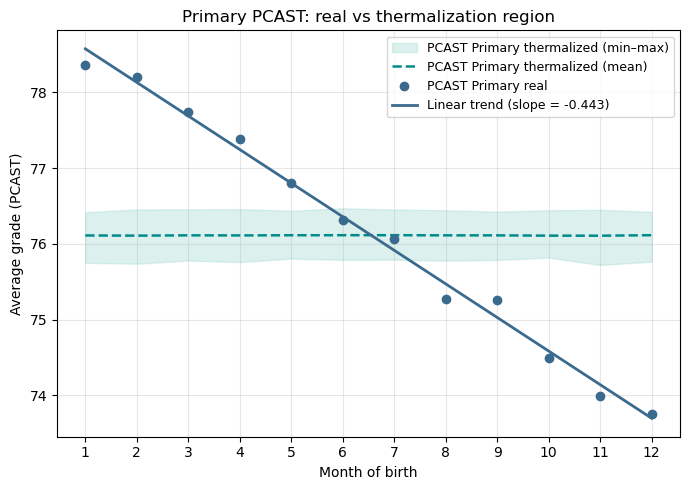

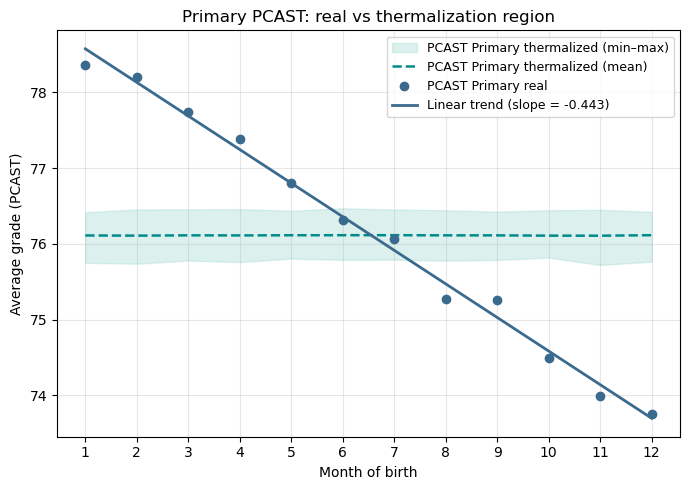

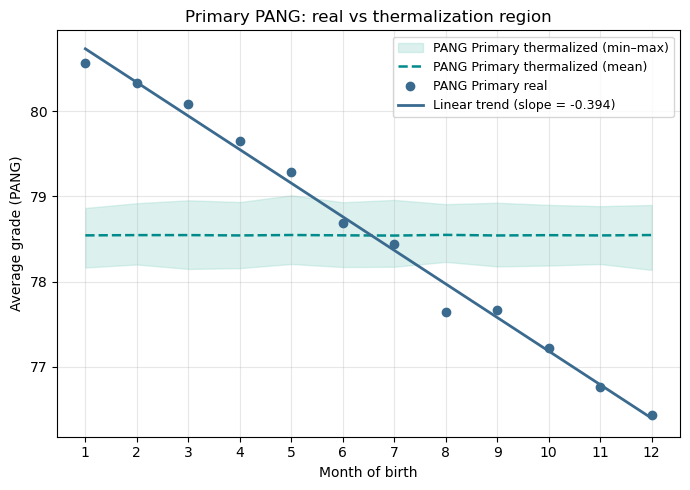

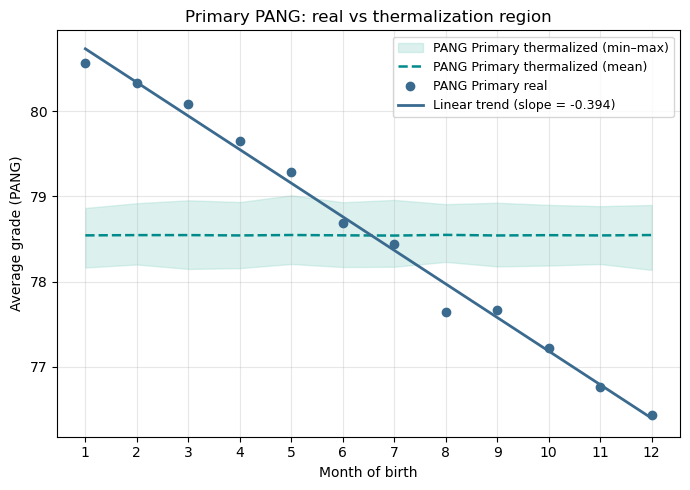

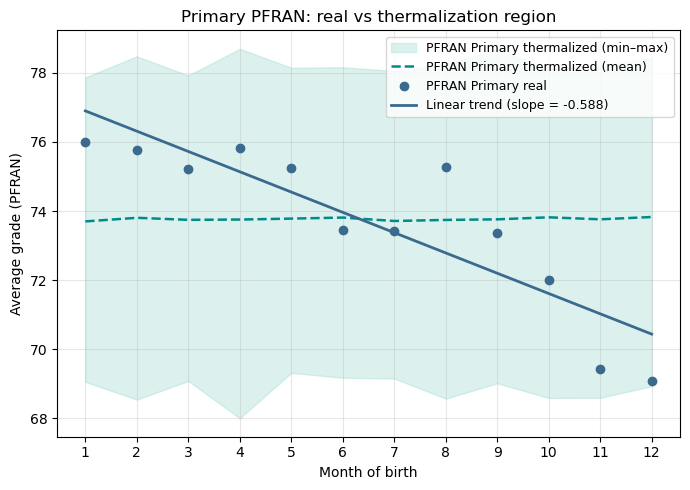

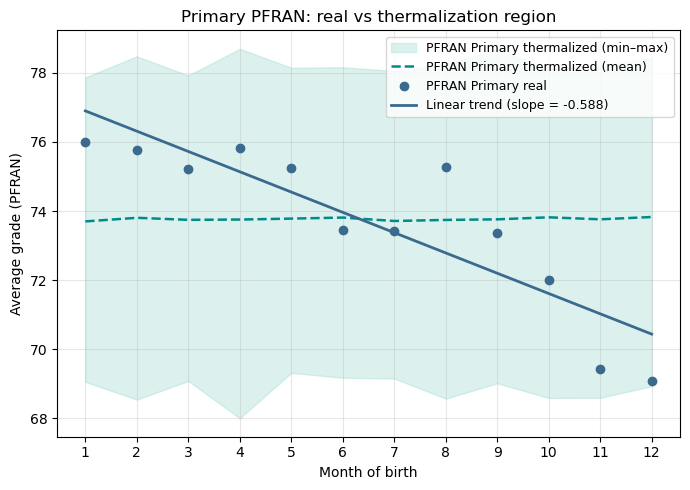

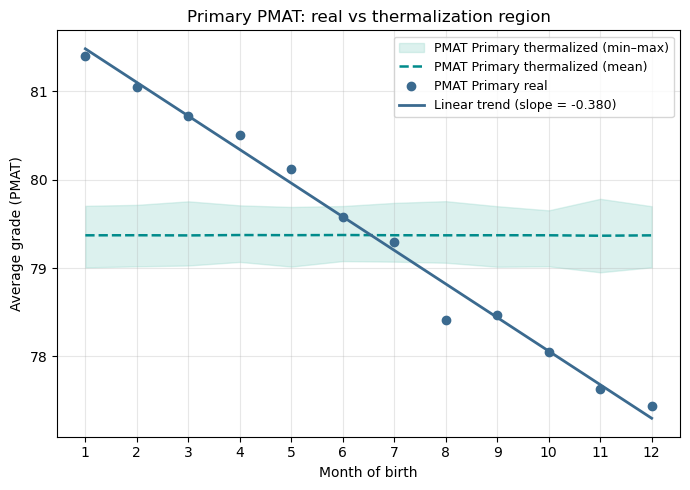

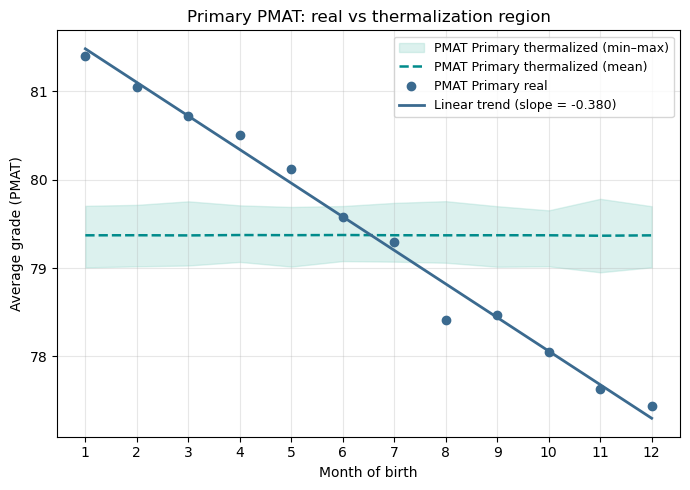

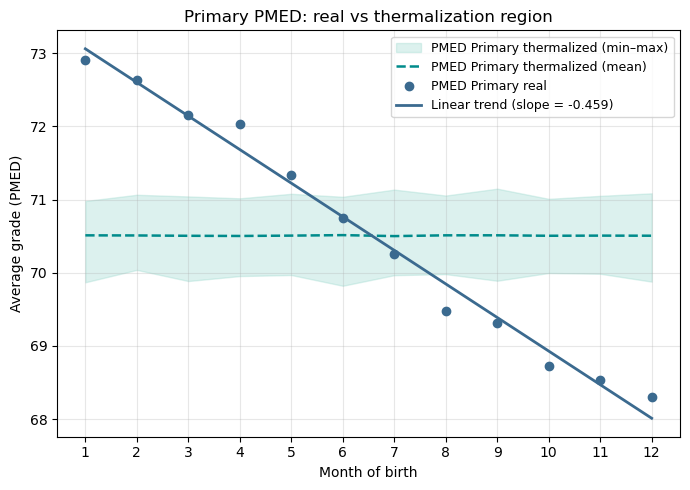

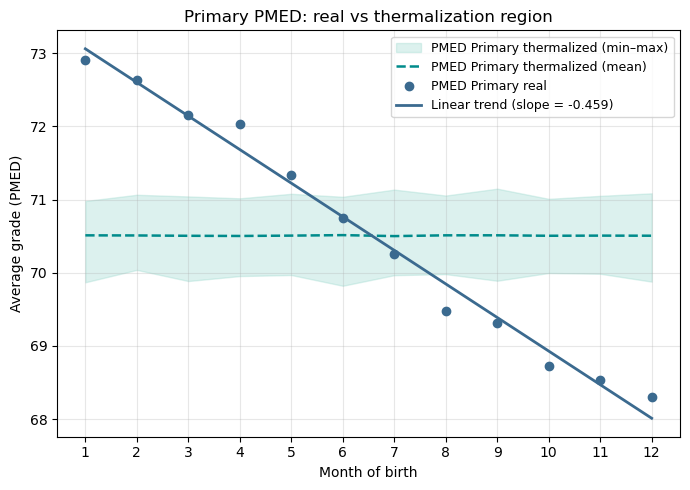

In [19]:
# --------------------------------------------------------
# 3. Plot and save all subjects
# --------------------------------------------------------

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

from scipy.stats import linregress

# --------------------------------------------------------
# 3. Plot and save all subjects (Primary)
# --------------------------------------------------------

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

for subj in subjects_P:
    summary_P = primary_summaries[subj]

    months    = summary_P['month'].values
    real_mean = summary_P['real_mean'].values
    band_min  = summary_P['band_min'].values
    band_max  = summary_P['band_max'].values
    band_mean = summary_P['null_mean'].values

    fig, ax = plt.subplots(figsize=(7, 5.0))

    # Base min–max thermalized band
    ax.fill_between(
        months, band_min, band_max,
        color='#8DD3C7', alpha=0.3,
        label=f'{subj} Primary thermalized (min–max)'
    )

    # Thermalized mean line
    ax.plot(
        months, band_mean,
        linestyle='--', linewidth=1.8, color='#008B8B',
        label=f'{subj} Primary thermalized (mean)'
    )

    # Real mean points (no line between them)
    ax.plot(
        months, real_mean,
        marker='o',
        linestyle='None',
        color='#3B6A8F',
        label=f'{subj} Primary real'
    )

    # ----- Linear regression on real means -----
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
    y_fit = intercept + slope * months

    # Regression line on the same axes
    ax.plot(
        months, y_fit,
        linewidth=2,
        linestyle='-',
        color='#3B6A8F',
        label=f'Linear trend (slope = {slope:.3f})'
    )

    # (Optionally re‑enable your fill_between to band_min/band_max here)

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Primary {subj}: real vs thermalization region')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    fig.tight_layout()

    # Save BEFORE closing/showing
    filename = f"primary_{subj}_thermalization.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')  # [web:49][web:105][web:109]

    plt.show()
    plt.close(fig)  # free memory and avoid state leakage in loops [web:101][web:103]

    summary_P = primary_summaries[subj]

    months    = summary_P['month'].values
    real_mean = summary_P['real_mean'].values
    band_min  = summary_P['band_min'].values
    band_max  = summary_P['band_max'].values
    band_mean = summary_P['null_mean'].values

    fig, ax = plt.subplots(figsize=(7, 5.0))

    # Base min–max thermalized band
    ax.fill_between(
        months, band_min, band_max,
        color='#8DD3C7', alpha=0.3,
        label=f'{subj} Primary thermalized (min–max)'
    )

    # Thermalized mean line
    ax.plot(
        months, band_mean,
        linestyle='--', linewidth=1.8, color='#008B8B',
        label=f'{subj} Primary thermalized (mean)'
    )

    # Real mean points (no connecting line)
    ax.plot(
        months, real_mean,
        marker='o',
        linestyle='None',      # <- this prevents joining with lines
        color='#3B6A8F',
        label=f'{subj} Primary real'
    )

    # ----- Linear regression on real means -----
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])

    y_fit = intercept + slope * months

    # Regression line
    ax.plot(
        months, y_fit,
        linewidth=2,
        linestyle='-',
        color='#3B6A8F',
        label=f'Linear trend (slope = {slope:.3f})'
    )

    # Optional: fill-from-real-to-band code can go here if you re-enable it

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Primary {subj}: real vs thermalization region')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    fig.tight_layout()

    filename = f"primary_{subj}_thermalization.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')

    plt.show()




In [20]:
#--------------------------
# SECONDARY MAIN SUBJECTS
#--------------------------
subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']
n_iter = 2000

# --------------------------------------------------------
# 2. Run analysis for all subjects
# --------------------------------------------------------
secondary_summaries = {}
secondary_sims = {}

for subj in subjects_S:
    df_subj_S = (
        df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    summary_S, sim_S = thermalize_subject_by_month(
        df_level=df_subj_S,
        grade_col='GRADE',
        n_iter=n_iter,
        seed=84  # different seed from Primary if you want
    )

    summary_S['subject'] = subj
    summary_S['snapshot'] = 'Secondary'

    secondary_summaries[subj] = summary_S
    secondary_sims[subj] = sim_S

# Long-format dataset with all Secondary stats
df_stats_secondary_all = pd.concat(secondary_summaries.values(), ignore_index=True)


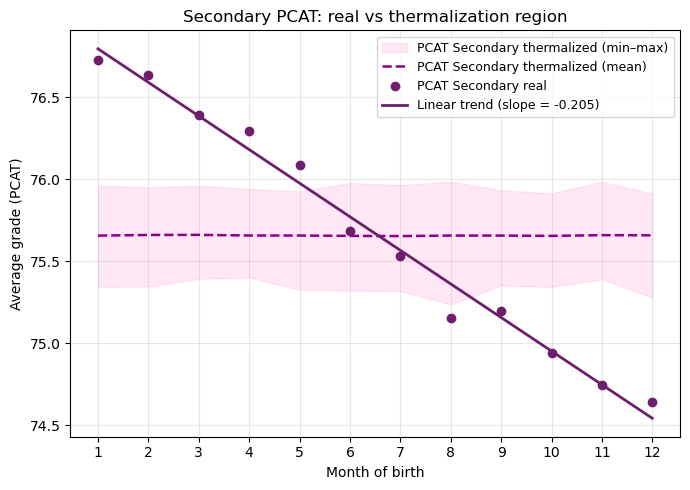

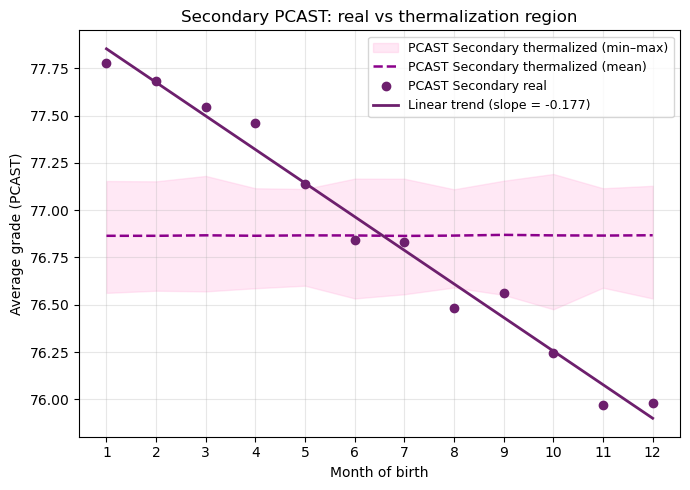

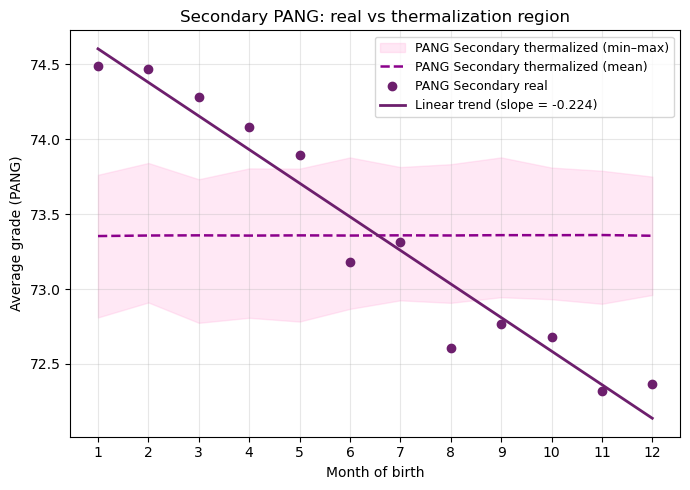

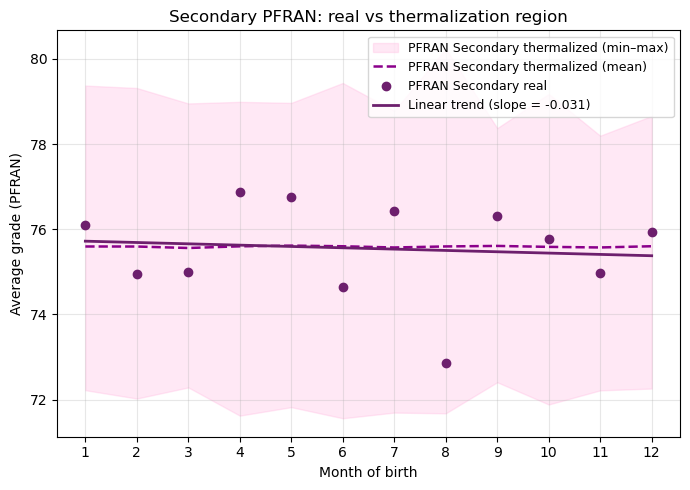

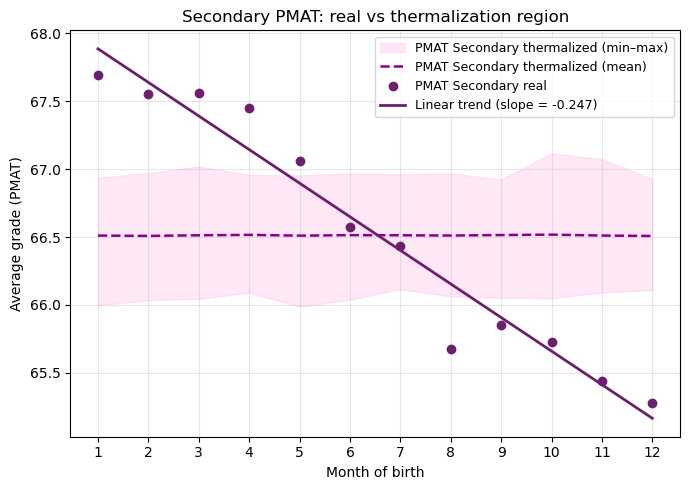

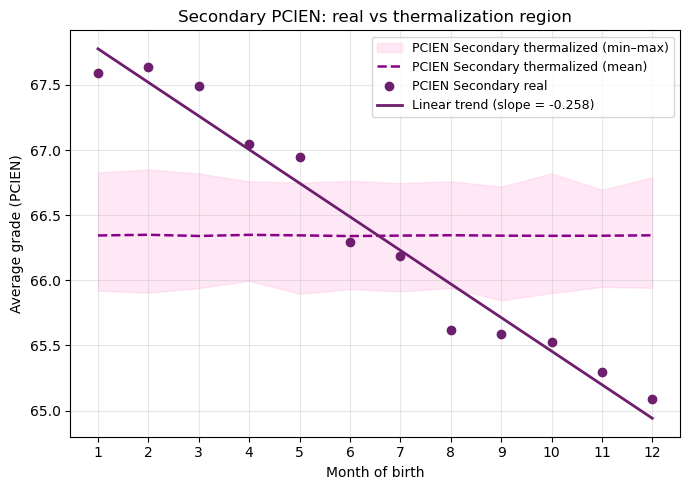

In [23]:
# --------------------------------------------------------
# 3. Plot for all subjects
# --------------------------------------------------------
plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

for subj in subjects_S:
    summary_S = secondary_summaries[subj]

    months    = summary_S['month'].values
    real_mean = summary_S['real_mean'].values
    band_min  = summary_S['band_min'].values
    band_max  = summary_S['band_max'].values
    band_mean = summary_S['null_mean'].values

    fig, ax = plt.subplots(figsize=(7, 5.0))

    # Base min–max thermalized band
    ax.fill_between(
        months, band_min, band_max,
        color='#FFB3DE', alpha=0.3,
        label=f'{subj} Secondary thermalized (min–max)'
    )

    # Thermalized mean line
    ax.plot(
        months, band_mean,
        linestyle='--', linewidth=1.8, color='#8B008B',
        label=f'{subj} Secondary thermalized (mean)'
    )

    # Real mean points (no connecting line)
    ax.plot(
        months, real_mean,
        marker='o',
        linestyle='None',      # prevents joining points with lines
        color='#6D1F6D',
        label=f'{subj} Secondary real'
    )

    # ----- Linear regression on real means -----
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
    y_fit = intercept + slope * months

    # Regression line
    ax.plot(
        months, y_fit,
        linewidth=2,
        linestyle='-',
        color='#6D1F6D',
        label=f'Linear trend (slope = {slope:.3f})'
    )

    # (Optional) re‑enable your fill_between to band_min/band_max here if desired

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Secondary {subj}: real vs thermalization region')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    fig.tight_layout()

    # Save to directory
    filename = f"secondary_{subj}_thermalization.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)




#### Statistics: TESTS!

In [24]:
def plot_summary_heatmaps(df_stats, level_label, filename_prefix):
    """
    df_stats: df_stats_primary_all or df_stats_secondary_all
              must contain columns: subject, month, z_score, iqr
    """
    # Ensure month is numeric and sorted
    df = df_stats.copy()
    df['month'] = pd.to_numeric(df['month'], errors='coerce')
    df = df.dropna(subset=['month'])

    # Sorted unique months
    months_sorted = sorted(df['month'].unique())

    # Pivot: rows = subject, columns = month
    z_pivot = (
        df.pivot_table(index='subject', columns='month', values='z_score')
          .reindex(columns=months_sorted)
    )
    iqr_pivot = (
        df.pivot_table(index='subject', columns='month', values='iqr')
          .reindex(columns=months_sorted)
    )

    fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

    # --- Z-score heatmap ---
    sns.heatmap(
        z_pivot,
        ax=axes[0],
        cmap=cmap_icefire,
        center=0,
        annot=True,
        fmt='.1f',
        cbar_kws={'label': 'Z-score'}
    )  # [web:69][web:74][web:66]
    axes[0].set_title(f'{level_label} – Z-scores by subject and month')
    axes[0].set_ylabel('Subject')

    # --- IQR heatmap ---
    sns.heatmap(
        iqr_pivot,
        ax=axes[1],
        cmap=cmap_icefire,
        annot=False,
        cbar_kws={'label': 'IQR of null means'}
    )  # [web:69][web:74][web:66]
    axes[1].set_title(f'{level_label} – IQR of thermalized null distribution')
    axes[1].set_xlabel('Month of birth')
    axes[1].set_ylabel('Subject')

    # Force x tick labels to be 1, 2, 3, ...
    month_labels = [str(int(m)) for m in months_sorted]
    for ax in axes:
        ax.set_xticks(np.arange(len(months_sorted)) + 0.5)  # center ticks on cells [web:78][web:81]
        ax.set_xticklabels(month_labels, rotation=0)

    fig.tight_layout()

    filename = f"{filename_prefix}_summary_heatmaps.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')  # [web:49][web:59]



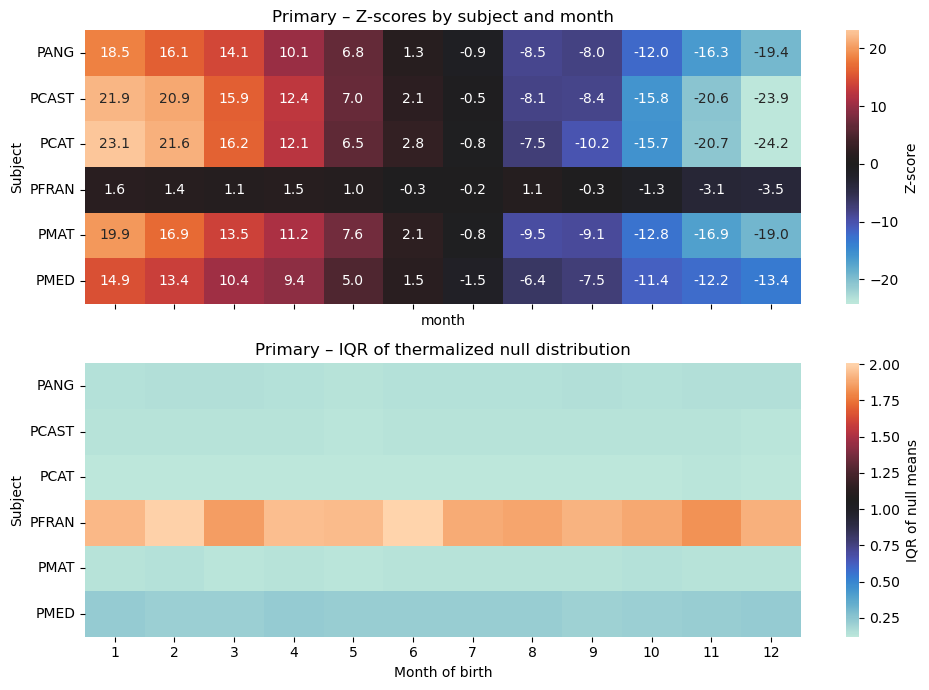

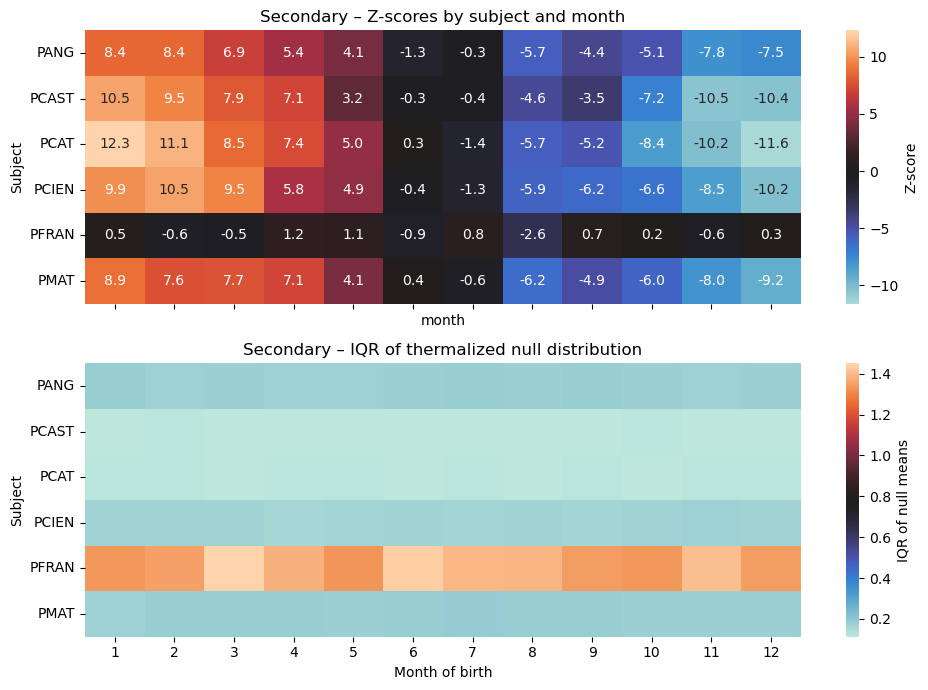

In [25]:
cmap_icefire = sns.color_palette("icefire", as_cmap=True)
plot_summary_heatmaps(df_stats_primary_all,  'Primary',   'primary')
plot_summary_heatmaps(df_stats_secondary_all, 'Secondary', 'secondary')


In [30]:
# ========== NO-GENDER COLOR PALETTE ==========

palette = {
    'primary': {
        'points': '#3B6A8F',                 # real means + regression line
        'thermalized_band': '#8DD3C7',       # min–max fill_between
        'thermalized_mean_line': '#008B8B',  # dashed null mean line
    },
    'secondary': {
        'points': '#6D1F6D',                 # real means + regression line
        'thermalized_band': '#FFB3DE',       # min–max fill_between
        'thermalized_mean_line': '#8B008B',  # dashed null mean line
    }
}


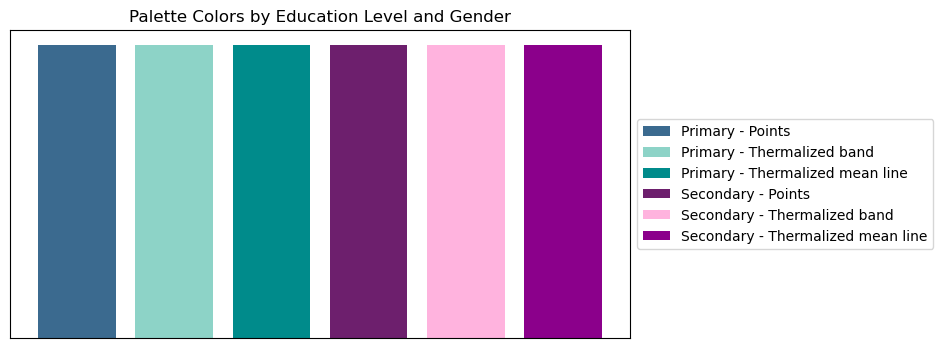

In [31]:
# Show the colors of the palette in a plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

x = 0
for level in palette:
    for key, color in palette[level].items():
        ax.bar(x, 1, color=color, label=f"{level.capitalize()} - {key.replace('_', ' ').capitalize()}")
        x += 1

ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Palette Colors by Education Level and Gender")
plt.show()

In [27]:
palette_gender = {
    'primary': {
        'male': {
            # slightly cooler/more blue than base #3B6A8F
            'points': '#315F92',
            'thermalized_band': '#80C4D9',       # lighter band
            'thermalized_mean_line': '#007A99',  # teal-blue line
        },
        'female': {
            # slightly more green-turquoise than base #3B6A8F
            'points': '#3B8F73',
            'thermalized_band': '#8DD9B3',       # lighter turquoise band
            'thermalized_mean_line': '#00996F',  # green-teal line
        }
    },
    'secondary': {
        'male': {
            # a bit more violet than base #6D1F6D
            'points': '#5E1F7D',
            'thermalized_band': '#E6B3FF',       # violet-leaning light band
            'thermalized_mean_line': '#7A008B',  # violet-magenta line
        },
        'female': {
            # a bit more magenta/red than base #6D1F6D
            'points': '#7D1F5E',
            'thermalized_band': '#FFB3C4',       # coral-pink light band
            'thermalized_mean_line': '#8B007A',  # magenta-leaning line
        }
    }
}


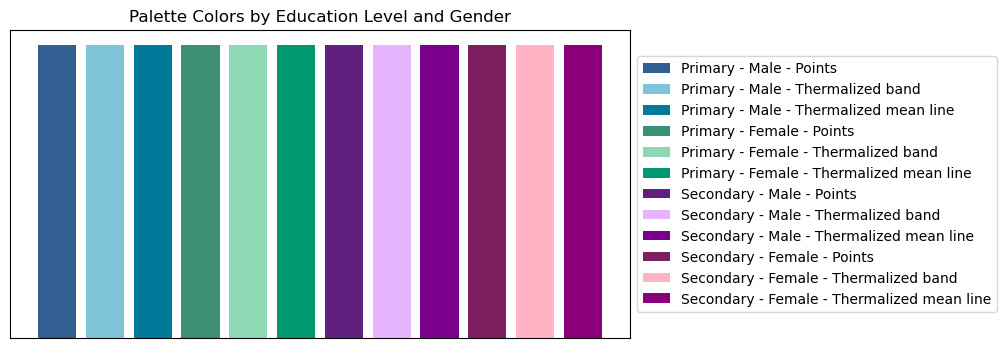

In [28]:
# Show the colors of the palette in a plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

x = 0
for level in palette_gender:
    for gender in palette_gender[level]:
        colors = palette_gender[level][gender]
        for key, color in colors.items():
            ax.bar(x, 1, color=color, label=f"{level.capitalize()} - {gender.capitalize()} - {key.replace('_', ' ').capitalize()}")
            x += 1

ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Palette Colors by Education Level and Gender")
plt.show()

NameError: name 'months' is not defined

- Fer les regressions lineals i agafar els pendents.

- Randomitzar les dades: com termalitzar, assignar cada nota a un mes de forma aleatòria.

    - Pintar el "fill between" entre les dades randomitzades i les reals.
    - Quan randomitzem, ho fem molts cops. 10, 20, 100 cops, no sé. Llavors, aquestes línies puntejades, fem una "línea gruixida" o ombra.
    - Després, quan pintem les notes mitjanes, volem veure si els punts entren dins d'aquesta regió ombrejada o no. Així podem determinar, amb el grau de confiança que volguem
    (com un 10% dins de la zona ombrejada) si realment aquest comportament entra dins del soroll esperable o no.

- Calcular el Z score.

- Calcular el rang interquartílic.

Use two statistic parameters to improve my study. So far, as I have my thermalized grades with the uncertainty, I can graphically tell that the mean grades by months are out of the thermalized region. That helps me determine that it is not a random fact, but something related to older kids performing better than younger. 

I think it woul be interesting to compute -the Z score. -  interquartílic range. How could I implement this? Also, I only have studied math grades, but I would like to do more. It would be interesting to see, at som point, only one plot that tells the whole story.


## 1. Initial plots

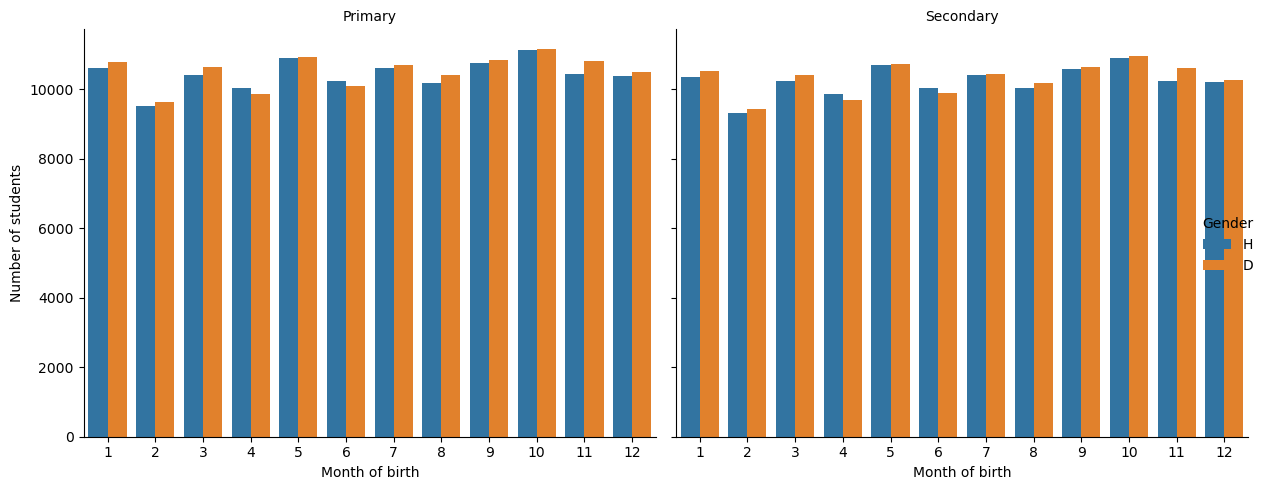

In [27]:
# ===============================
# Plot 1 (gender): Birth months by gender and level
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Unique students with month of birth and gender for each level
df_birth_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE']].drop_duplicates()
df_birth_P['snapshot'] = 'Primary'

df_birth_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE']].drop_duplicates()
df_birth_S['snapshot'] = 'Secondary'

# Combine for plotting
df_birth = pd.concat([df_birth_P, df_birth_S], ignore_index=True)

# Order months 1..12
df_birth['MES_NAIXEMENT'] = pd.Categorical(
    df_birth['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)

# (Optional) map numeric gender codes to labels
# df_birth['GENERE'] = df_birth['GENERE'].replace({1: 'Male', 2: 'Female'})

# Two-panel countplot: one for Primary, one for Secondary
g = sns.catplot(
    data=df_birth,
    x='MES_NAIXEMENT',
    hue='GENERE',
    col='snapshot',
    kind='count',
    height=5,
    aspect=1.2,
    sharey=True
)

g.set_axis_labels('Month of birth', 'Number of students')
g.set_titles('{col_name}')
g._legend.set_title('Gender')

plt.tight_layout()
plt.show()



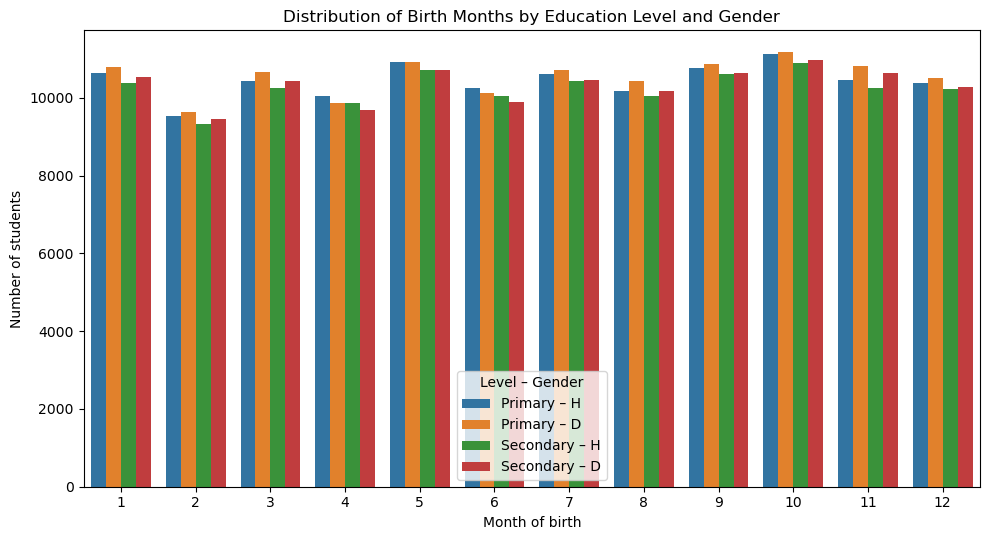

In [28]:
# ===============================
# Plot 1 (gender): Birth months by level & gender (single plot)
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Unique students with month of birth and gender for each level
df_birth_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE']].drop_duplicates()
df_birth_P['snapshot'] = 'Primary'

df_birth_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE']].drop_duplicates()
df_birth_S['snapshot'] = 'Secondary'

# Combine for plotting
df_birth = pd.concat([df_birth_P, df_birth_S], ignore_index=True)

# Order months 1..12
df_birth['MES_NAIXEMENT'] = pd.Categorical(
    df_birth['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)

# (Optional) map numeric gender codes to labels
# df_birth['GENERE'] = df_birth['GENERE'].replace({1: 'Male', 2: 'Female'})

# Create combined level+gender category: e.g. "Primary – Male", "Secondary – Female"
df_birth['level_gender'] = (
    df_birth['snapshot'].astype(str) + ' – ' + df_birth['GENERE'].astype(str)
)

plt.figure(figsize=(10, 5.5))
sns.countplot(
    data=df_birth,
    x='MES_NAIXEMENT',
    hue='level_gender'
)  # four bars per month: P–M, P–F, S–M, S–F [web:121][web:126]

plt.title('Distribution of Birth Months by Education Level and Gender')
plt.xlabel('Month of birth')
plt.ylabel('Number of students')
plt.legend(title='Level – Gender')
plt.tight_layout()
plt.show()


## 3. Generalized

### Thermalization

In [30]:
# --------------------------------------------------------
# 1. Thermalize one subject 
# --------------------------------------------------------

def thermalize_subject_by_month(df_level, grade_col, n_iter=2000, seed=42):
    """
    df_level: dataframe with at least ['MES_NAIXEMENT', grade_col]
    grade_col: name of the grade column (string)

    Returns
    -------
    summary : DataFrame with month-level stats:
        month, real_mean, null_mean, null_std, null_median,
        q1, q3, iqr, z_score, z_iqr, band_min, band_max
    sim : np.ndarray of shape (n_iter, 12)
        simulated null means per month (months 1..12)
    """
    df = df_level[['MES_NAIXEMENT', grade_col]].copy()
    df['MES_NAIXEMENT'] = pd.to_numeric(df['MES_NAIXEMENT'], errors='coerce')
    df = df.dropna(subset=['MES_NAIXEMENT', grade_col])

    months = np.arange(1, 13)

    # Real mean per month on full grid 1..12
    real_means = (
        df.groupby('MES_NAIXEMENT')[grade_col]
          .mean()
          .reindex(months, fill_value=np.nan)
    )
    real_mean = real_means.values

    # Simulations: null distribution via month randomization
    rng = np.random.default_rng(seed)
    sim = np.full((n_iter, len(months)), np.nan)

    for i in range(n_iter):
        months_rand = rng.integers(1, 13, size=len(df))
        tmp = df.copy()
        tmp['MES_NAIXEMENT_TH'] = months_rand
        m = tmp.groupby('MES_NAIXEMENT_TH')[grade_col].mean()

        arr = np.full(len(months), np.nan)
        for m_idx, val in m.items():
            if 1 <= m_idx <= 12:
                arr[m_idx - 1] = val
        sim[i, :] = arr

    # Null distribution summaries
    null_mean = np.nanmean(sim, axis=0)
    null_std  = np.nanstd(sim,  axis=0, ddof=1)
    null_med  = np.nanmedian(sim, axis=0)
    q1, q3    = np.nanpercentile(sim, [25, 75], axis=0)
    iqr       = q3 - q1

    # Z-score and robust z (IQR-based)
    z = (real_mean - null_mean) / null_std
    z_iqr = (real_mean - null_med) / iqr

    # Min–max band for visualization
    band_min = np.nanmin(sim, axis=0)
    band_max = np.nanmax(sim, axis=0)

    summary = pd.DataFrame({
        'month': months,
        'real_mean': real_mean,
        'null_mean': null_mean,
        'null_std': null_std,
        'null_median': null_med,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'z_score': z,
        'z_iqr': z_iqr,
        'band_min': band_min,
        'band_max': band_max
    })

    return summary, sim
    """
    df_level: dataframe with at least ['MES_NAIXEMENT', grade_col],
              already filtered to the subgroup (e.g. Primary + girls)
    grade_col: name of the grade column (string)

    Returns:
        summary: DataFrame with month-level stats (real mean, null mean, z, IQR, band, ...)
        sim:     array of shape (n_iter, 12) with simulated null means per month
    """
    df = df_level[['MES_NAIXEMENT', grade_col]].copy()
    df['MES_NAIXEMENT'] = pd.to_numeric(df['MES_NAIXEMENT'], errors='coerce')
    df = df.dropna(subset=['MES_NAIXEMENT', grade_col])

    months = np.arange(1, 13)

    # Real mean per month, aligned on full 1..12 grid
    real_means = (
        df.groupby('MES_NAIXEMENT')[grade_col]
          .mean()
          .reindex(months, fill_value=np.nan)
    )
    real_mean = real_means.values

    # Simulations: null distribution by randomizing months
    rng = np.random.default_rng(seed)
    sim = np.full((n_iter, len(months)), np.nan)

    for i in range(n_iter):
        months_rand = rng.integers(1, 13, size=len(df))
        tmp = df.copy()
        tmp['MES_NAIXEMENT_TH'] = months_rand
        m = tmp.groupby('MES_NAIXEMENT_TH')[grade_col].mean()

        arr = np.full(len(months), np.nan)
        for m_idx, val in m.items():
            if 1 <= m_idx <= 12:
                arr[m_idx - 1] = val
        sim[i, :] = arr

    # Null distribution summaries
    null_mean = np.nanmean(sim, axis=0)
    null_std  = np.nanstd(sim,  axis=0, ddof=1)
    null_med  = np.nanmedian(sim, axis=0)
    q1, q3    = np.nanpercentile(sim, [25, 75], axis=0)
    iqr       = q3 - q1

    # Z-score and robust z (IQR-based)
    z = (real_mean - null_mean) / null_std
    z_iqr = (real_mean - null_med) / iqr

    # Min–max band for visualization
    band_min = np.nanmin(sim, axis=0)
    band_max = np.nanmax(sim, axis=0)

    summary = pd.DataFrame({
        'month': months,
        'real_mean': real_mean,
        'null_mean': null_mean,
        'null_std': null_std,
        'null_median': null_med,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'z_score': z,
        'z_iqr': z_iqr,
        'band_min': band_min,
        'band_max': band_max
    })

    return summary, sim


In [31]:
# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS – by gender
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# Distinct gender codes present in Primary
genders_P = sorted(df_P['GENERE'].dropna().unique())

# --------------------------------------------------------
# 2. Run analysis for all subjects, split by gender
# --------------------------------------------------------
primary_summaries_gender = {}   # dict: (subj, gender) -> summary DataFrame
primary_sims_gender = {}        # dict: (subj, gender) -> sim array
all_summaries = []

for subj in subjects_P:
    # Base dataframe for this subject in Primary
    base_df = (
        df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    for gen in genders_P:
        df_subj_gen = base_df[base_df['GENERE'] == gen].copy()

        # If no valid grades for this gender+subject, skip
        if df_subj_gen['GRADE'].dropna().empty:
            continue

        summary_P, sim_P = thermalize_subject_by_month(
            df_level=df_subj_gen,
            grade_col='GRADE',
            n_iter=n_iter,
            seed=42  # can vary by subject/gender if desired
        )

        summary_P['subject'] = subj
        summary_P['snapshot'] = 'Primary'
        summary_P['gender'] = gen

        primary_summaries_gender[(subj, gen)] = summary_P
        primary_sims_gender[(subj, gen)] = sim_P
        all_summaries.append(summary_P)

# Long-format dataset with all Primary stats by gender (includes z_score and z_iqr)
df_stats_primary_gender_all = pd.concat(all_summaries, ignore_index=True)


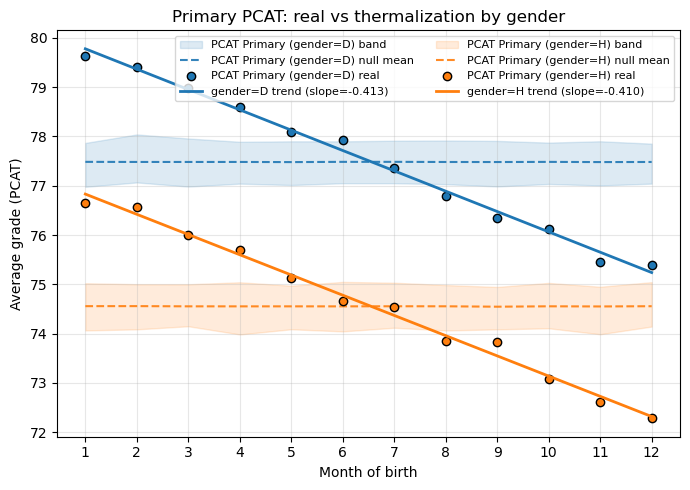

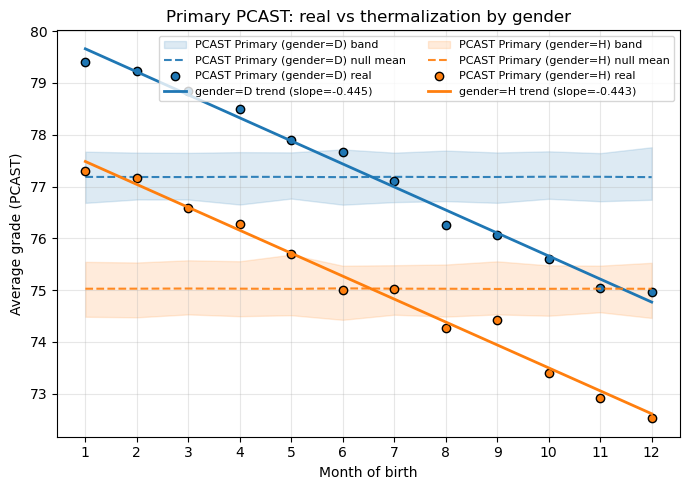

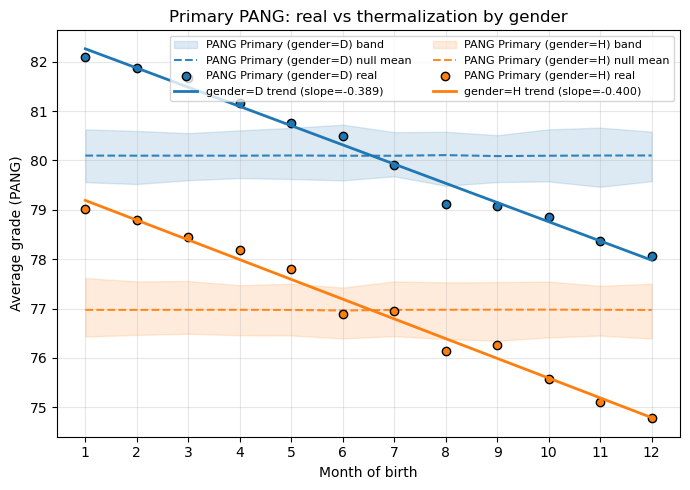

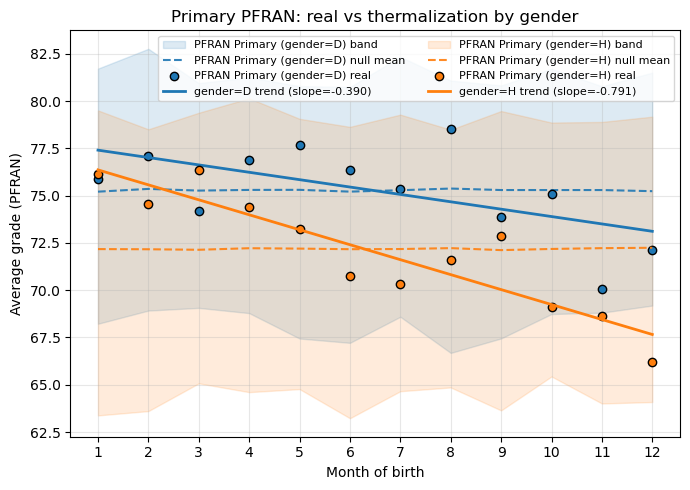

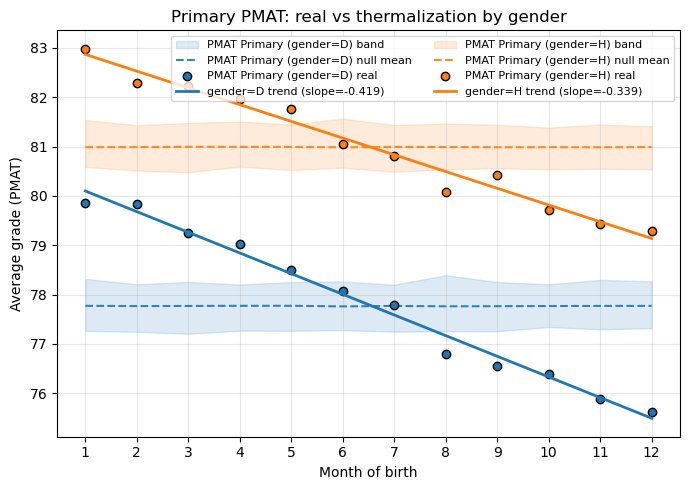

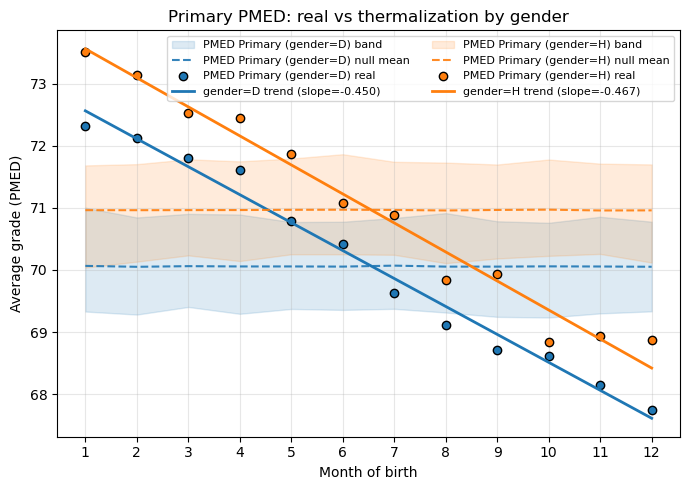

In [33]:
from scipy.stats import linregress
import os

# --------------------------------------------------------
# 3. Plot and save all subjects (Primary, by gender)
# --------------------------------------------------------

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

# Simple color mapping per gender code (adjust to your GENERE coding)
gender_color_map = {}
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # use first 2 for M/F typically
for gen, col in zip(genders_P, palette):
    gender_color_map[gen] = col

for subj in subjects_P:
    fig, ax = plt.subplots(figsize=(7, 5.0))

    for gen in genders_P:
        key = (subj, gen)
        if key not in primary_summaries_gender:
            continue  # no data for this subject+gender

        summary_P = primary_summaries_gender[key]

        months    = summary_P['month'].values
        real_mean = summary_P['real_mean'].values
        band_min  = summary_P['band_min'].values
        band_max  = summary_P['band_max'].values
        band_mean = summary_P['null_mean'].values

        color = gender_color_map.get(gen, '#3B6A8F')

        # Base min–max thermalized band for this gender
        ax.fill_between(
            months, band_min, band_max,
            color=color, alpha=0.15,
            label=f'{subj} Primary (gender={gen}) band'
        )

        # Thermalized mean line
        ax.plot(
            months, band_mean,
            linestyle='--', linewidth=1.5, color=color,
            alpha=0.9,
            label=f'{subj} Primary (gender={gen}) null mean'
        )

        # Real mean points (no connecting line)
        ax.plot(
            months, real_mean,
            marker='o',
            linestyle='None',
            color=color,
            markeredgecolor='black',
            label=f'{subj} Primary (gender={gen}) real'
        )

        # ----- Linear regression on real means -----
        mask = ~np.isnan(months) & ~np.isnan(real_mean)
        if mask.sum() >= 2:
            slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
            y_fit = intercept + slope * months

            # Regression line
            ax.plot(
                months, y_fit,
                linewidth=2,
                linestyle='-',
                color=color,
                label=f'gender={gen} trend (slope={slope:.3f})'
            )

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Primary {subj}: real vs thermalization by gender')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, ncol=2)
    fig.tight_layout()

    # Save BEFORE closing/showing
    filename = f"primary_{subj}_by_gender_thermalization.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight') 

    plt.show()
    plt.close(fig) 


In [35]:
# --------------------------------------------------------
# SECONDARY MAIN SUBJECTS – by gender
# --------------------------------------------------------
subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']
n_iter = 2000

# Distinct gender codes present in Primary
genders_S = sorted(df_S['GENERE'].dropna().unique())

# --------------------------------------------------------
# 2. Run analysis for all subjects, split by gender
# --------------------------------------------------------
secondary_summaries_gender = {}   # dict: (subj, gender) -> summary DataFrame
secondary_sims_gender = {}        # dict: (subj, gender) -> sim array
all_summaries = []

for subj in subjects_S:
    # Base dataframe for this subject in Secondary
    base_df = (
        df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    for gen in genders_S:
        df_subj_gen = base_df[base_df['GENERE'] == gen].copy()

        # If no valid grades for this gender+subject, skip
        if df_subj_gen['GRADE'].dropna().empty:
            continue

        summary_S, sim_S = thermalize_subject_by_month(
            df_level=df_subj_gen,
            grade_col='GRADE',
            n_iter=n_iter,
            seed=42  # can vary by subject/gender if desired
        )

        summary_S['subject'] = subj
        summary_S['snapshot'] = 'Secondary'
        summary_S['gender'] = gen

        secondary_summaries_gender[(subj, gen)] = summary_S
        secondary_sims_gender[(subj, gen)] = sim_S
        all_summaries.append(summary_S)

# Long-format dataset with all Secondary stats by gender (includes z_score and z_iqr)
df_stats_secondary_gender_all = pd.concat(all_summaries, ignore_index=True)

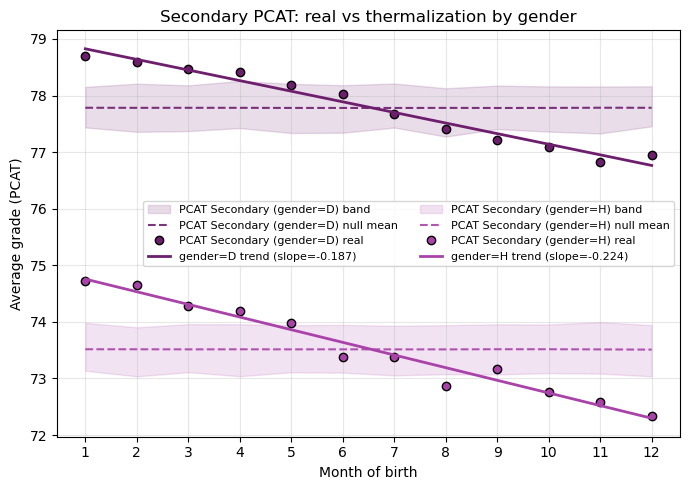

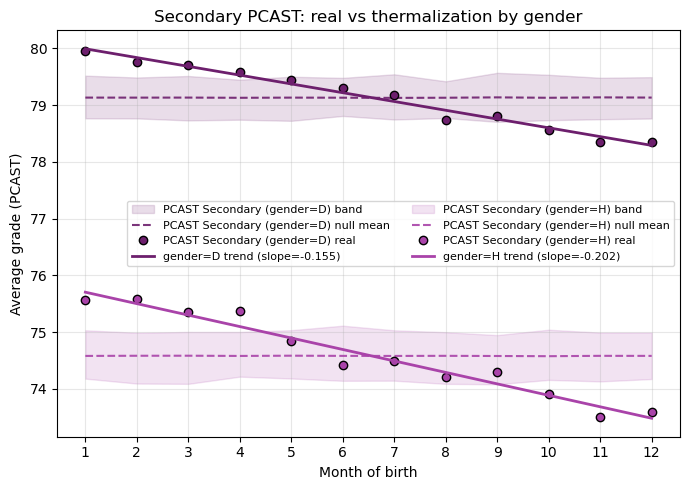

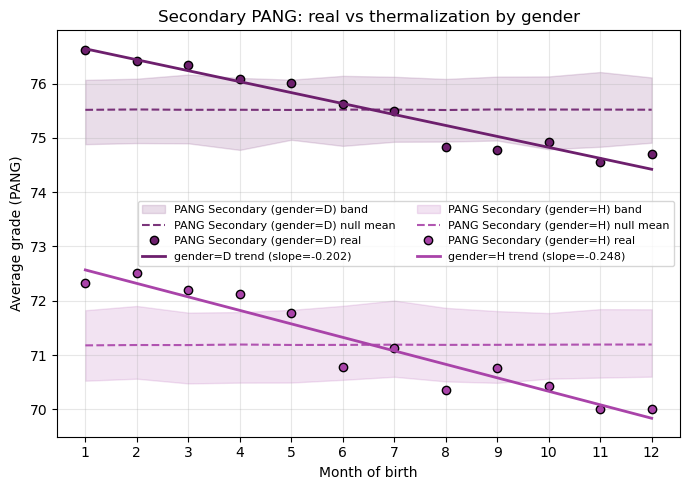

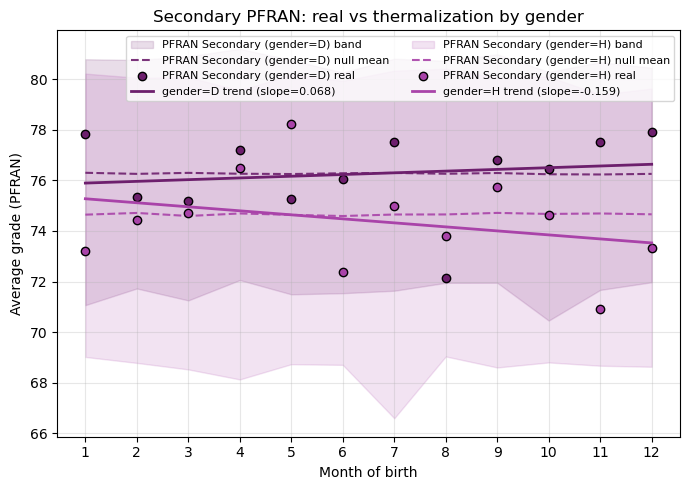

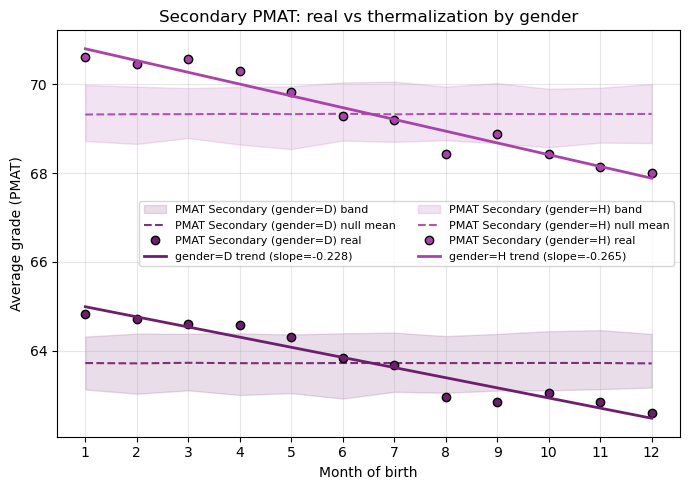

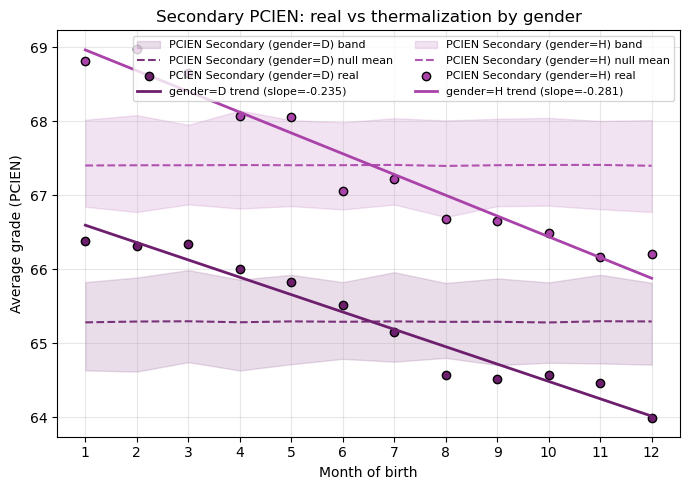

In [36]:
# --------------------------------------------------------
# Plot and save all subjects (Secondary, by gender)
# --------------------------------------------------------

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

# Simple color mapping per gender code (adjust to your GENERE coding)
gender_color_map_S = {}
palette_S = ['#6D1F6D', '#A943A9', '#1f77b4', '#ff7f0e']  # first 2 for main genders
for gen, col in zip(genders_S, palette_S):
    gender_color_map_S[gen] = col

for subj in subjects_S:
    fig, ax = plt.subplots(figsize=(7, 5.0))

    for gen in genders_S:
        key = (subj, gen)
        if key not in secondary_summaries_gender:
            continue  # no data for this subject+gender

        summary_S = secondary_summaries_gender[key]

        months    = summary_S['month'].values
        real_mean = summary_S['real_mean'].values
        band_min  = summary_S['band_min'].values
        band_max  = summary_S['band_max'].values
        band_mean = summary_S['null_mean'].values

        color = gender_color_map_S.get(gen, '#6D1F6D')

        # Base min–max thermalized band for this gender
        ax.fill_between(
            months, band_min, band_max,
            color=color, alpha=0.15,
            label=f'{subj} Secondary (gender={gen}) band'
        )

        # Thermalized mean line
        ax.plot(
            months, band_mean,
            linestyle='--', linewidth=1.5, color=color, alpha=0.9,
            label=f'{subj} Secondary (gender={gen}) null mean'
        )

        # Real mean points (no connecting line)
        ax.plot(
            months, real_mean,
            marker='o',
            linestyle='None',
            color=color,
            markeredgecolor='black',
            label=f'{subj} Secondary (gender={gen}) real'
        )

        # ----- Linear regression on real means -----
        mask = ~np.isnan(months) & ~np.isnan(real_mean)
        if mask.sum() >= 2:
            slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
            y_fit = intercept + slope * months

            # Regression line
            ax.plot(
                months, y_fit,
                linewidth=2,
                linestyle='-',
                color=color,
                label=f'gender={gen} trend (slope={slope:.3f})'
            )

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Secondary {subj}: real vs thermalization by gender')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, ncol=2)
    fig.tight_layout()

    # Save to directory
    filename = f"secondary_{subj}_by_gender_thermalization.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)
